# Time Series Movement Prediction Using Wavelet-Based xLSTM-TS Model

**Notebook 2**: S&P 500 - Hourly Prices

---


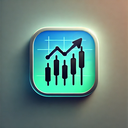

## Requirements

**Note**: Run with T4 GPU in Google Colab!

In [2]:
import os

# Store the repository URL
repo_url = 'https://github.com/gonzalopezgil/xlstm-ts.git'

# Clone the repository using HTTPS
!git clone {repo_url}

Cloning into 'xlstm-ts'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 206 (delta 111), reused 141 (delta 52), pack-reused 0
Receiving objects: 100% (206/206), 2.17 MiB | 24.10 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [3]:
%cd xlstm-ts

/content/xlstm-ts


In [4]:
!pip install -r requirements.txt --quiet

In [5]:
os.environ['TIINGO_API_KEY'] = '' # Add your Tiingo API key here

In [6]:
# Add the src directory to the Python path
import sys
sys.path.append('/content/xlstm-ts/src')

In [7]:
from ml.utils.imports import *

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Dataset

**S&P 500 (US)**

https://finance.yahoo.com/quote/%5EGSPC/

For hourly data:

The SPDR S&P 500 ETF Trust (SPY), also known as SPY, is an exchange-traded fund that tracks the performance of the S&P 500 index

It is chosen due to the unavailability of the S&P 500 in the Tiingo library.

In [8]:
from ml.data.download import download_data, plot_data

In [9]:
start_date = '2020-07-01'

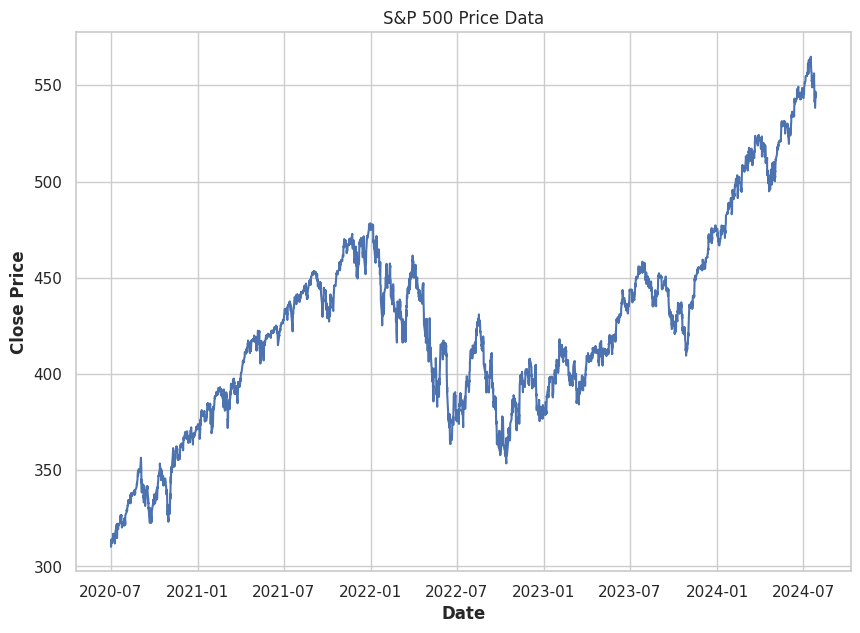

In [10]:
# Download the data
sp500_df = download_data('SPY', start_date, freq='hourly')

stock = 'S&P 500'

# Plot the raw data
plot_data(sp500_df, stock)

## Preprocessing

### Wavelet denoising

Reference:
https://doi.org/10.1002/for.3071 (the idea of the wavelet denoising and some parameters are taken from this paper)

In [11]:
from ml.data.preprocessing import wavelet_denoising, plot_wavelet_denoising

Signal-to-Noise Ratio (SNR): 56.80 dB


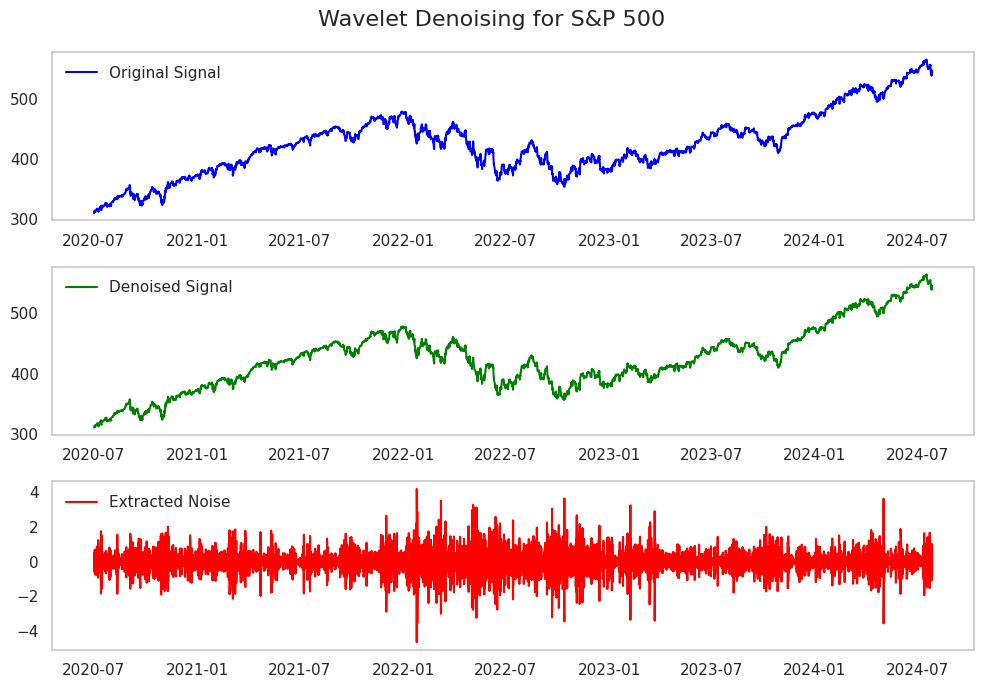

In [12]:
# Apply denoising
sp500_df['Close_denoised'] = wavelet_denoising(sp500_df['Close'])
sp500_df['Noise'] = sp500_df['Close'] - sp500_df['Close_denoised']

plot_wavelet_denoising(sp500_df, stock)

### Process dates

In [13]:
from ml.data.preprocessing import process_dates

In [14]:
# Convert the Date column to time zone-naive datetime
sp500_df = process_dates(sp500_df)

### Model-specific preprocessing

#### For darts library models

##### Convert to darts TimeSeries

**Darts Library**:

- Paper: https://www.jmlr.org/papers/v23/21-1177.html
- Documentation: https://unit8co.github.io/darts/README.html#
- Repository: https://github.com/unit8co/darts

In [15]:
from ml.darts.preprocessing import convert_to_ts_hourly

In [16]:
sp500_series, sp500_series_denoised = convert_to_ts_hourly(sp500_df)
sp500_series_denoised

<TimeSeries (DataArray) (time: 6378, component: 1, sample: 1)> Size: 51kB
array([[[310.39385676]],

       [[310.47388238]],

       [[310.80044247]],

       ...,

       [[545.81131834]],

       [[544.02714936]],

       [[543.63460104]]])
Coordinates:
  * time       (time) datetime64[ns] 51kB 2020-07-01T14:00:00 ... 2024-07-26T...
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

##### Train, Validation and Test split

*   **Train**: 07/2020 - 06/2023
*   **Validation**: 07/2023 - 12/2023
*   **Test**: 01/2024 - 07/2024

In [17]:
from ml.darts.preprocessing import split_train_val_test_darts

In [18]:
# Split the data by date
train_end_date = datetime.datetime(2023, 7, 1)
val_end_date = datetime.datetime(2024, 1, 1)

In [19]:
train, val, test = split_train_val_test_darts(sp500_series, train_end_date, val_end_date)
train_denoised, val_denoised, test_denoised = split_train_val_test_darts(sp500_series_denoised, train_end_date, val_end_date)

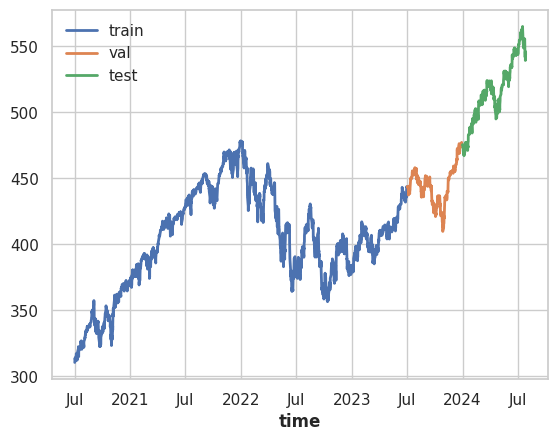

In [20]:
train_denoised.plot(label="train");
val_denoised.plot(label="val");
test_denoised.plot(label="test");

##### Normalise data

In [21]:
from ml.darts.preprocessing import normalise_split_data_darts

In [22]:
train, val, test, scaler_darts = normalise_split_data_darts(train, val, test)
train_denoised, val_denoised, test_denoised, scaler_darts_denoised = normalise_split_data_darts(train_denoised, val_denoised, test_denoised)

#### For the proposed model

##### Normalise data

In [23]:
from ml.xlstm_ts.preprocessing import normalise_data_xlstm

In [24]:
sp500_close_scaled, scaler = normalise_data_xlstm(sp500_df['Close'].values)

In [25]:
sp500_close_scaled_denoised, scaler_denoised = normalise_data_xlstm(sp500_df['Close_denoised'].values)

##### Create sequences

In [26]:
from ml.xlstm_ts.preprocessing import create_sequences

In [27]:
X, y, dates = create_sequences(sp500_close_scaled, sp500_df.index)

In [28]:
X_denoised, y_denoised, _ = create_sequences(sp500_close_scaled_denoised, sp500_df.index)

##### Train, Validation and Test split

*   **Train**: 07/2020 - 06/2023
*   **Validation**: 07/2023 - 12/2023
*   **Test**: 01/2024 - 07/2024



In [29]:
from ml.xlstm_ts.preprocessing import split_train_val_test_xlstm

train X shape: torch.Size([4548, 150, 1])
train y shape: torch.Size([4548, 1])
val X shape: torch.Size([780, 150, 1])
val y shape: torch.Size([780, 1])
test X shape: torch.Size([900, 150, 1])
test y shape: torch.Size([900, 1])


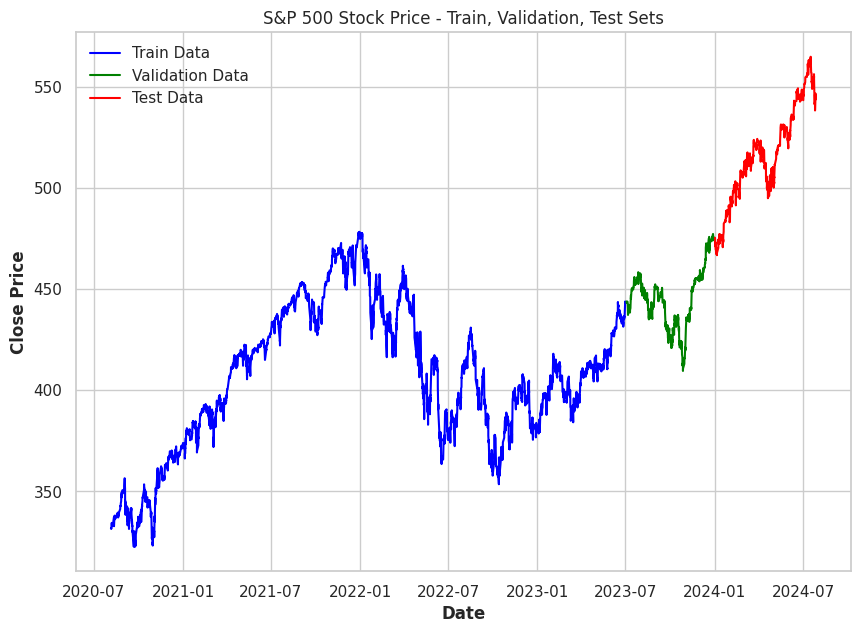

In [30]:
train_X, train_y, train_dates, val_X, val_y, val_dates, test_X, test_y, test_dates = split_train_val_test_xlstm(X, y, dates, train_end_date, val_end_date, scaler, stock)

train X shape: torch.Size([4548, 150, 1])
train y shape: torch.Size([4548, 1])
val X shape: torch.Size([780, 150, 1])
val y shape: torch.Size([780, 1])
test X shape: torch.Size([900, 150, 1])
test y shape: torch.Size([900, 1])


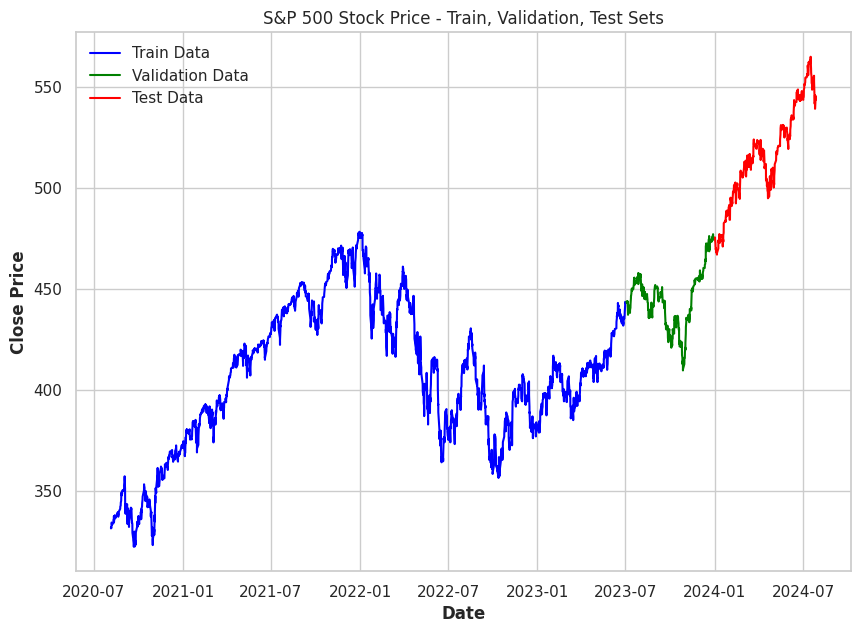

In [31]:
train_X_denoised, train_y_denoised, _, val_X_denoised, val_y_denoised, _, test_X_denoised, test_y_denoised, _ = split_train_val_test_xlstm(X_denoised, y_denoised, dates, train_end_date, val_end_date, scaler_denoised, stock)

## Models

In [32]:
from ml.models.models import *
from ml.darts.models import *

In [33]:
metrics_accumulator = {}
metrics_accumulator_denoised = {}

### TCN

**References**:

- Paper (2018): https://doi.org/10.48550/arXiv.1803.01271
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/05-TCN-examples.html

**Not denoised**

Price Prediction Metrics:

TCN (Original) | MAE: 1.05
TCN (Original) | MSE: 2.39
TCN (Original) | RMSE: 1.55
TCN (Original) | RMSSE: 1.04
TCN (Original) | MAPE: 0.20%
TCN (Original) | MASE: 1.11
TCN (Original) | R2: 0.99


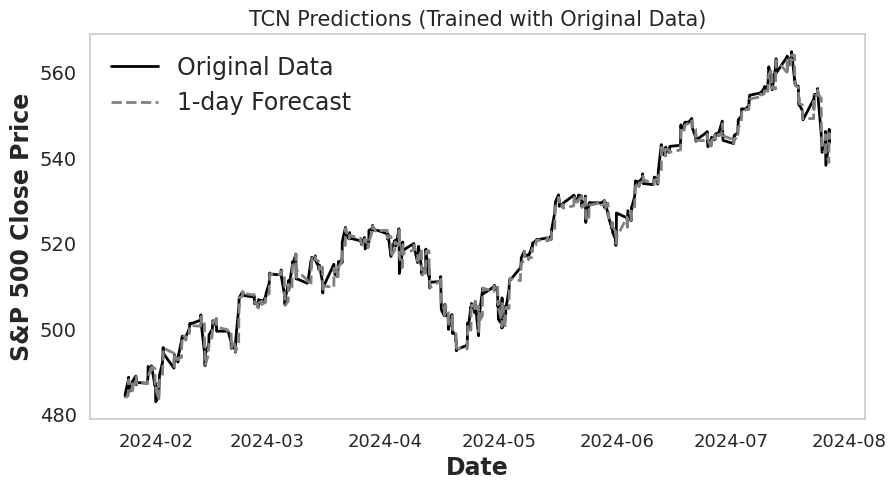

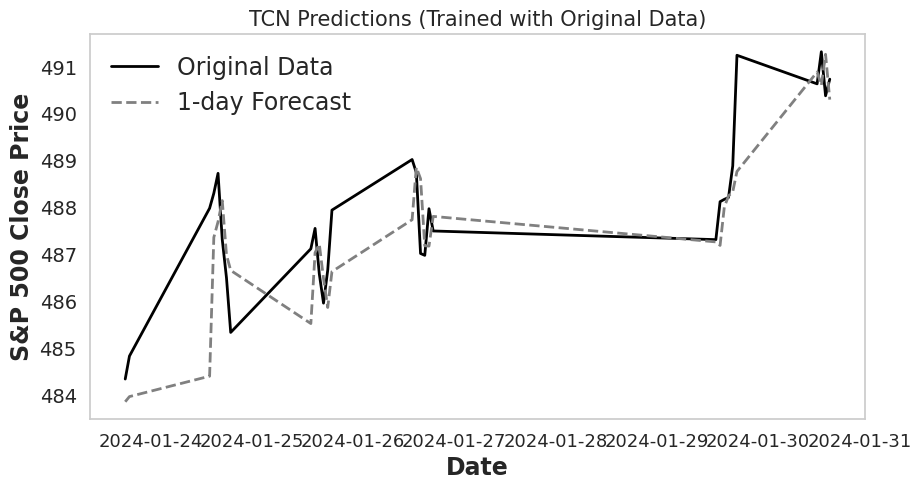


Directional Movement Metrics:

TCN (Original) | Train Accuracy: 50.55%
TCN (Original) | Validation Accuracy: 49.19%
TCN (Original) | Test Accuracy: 51.06%
TCN (Original) | Recall: 55.61%
TCN (Original) | Precision (Rise): 52.17%
TCN (Original) | Precision (Fall): 49.72%
TCN (Original) | F1 Score: 53.84%


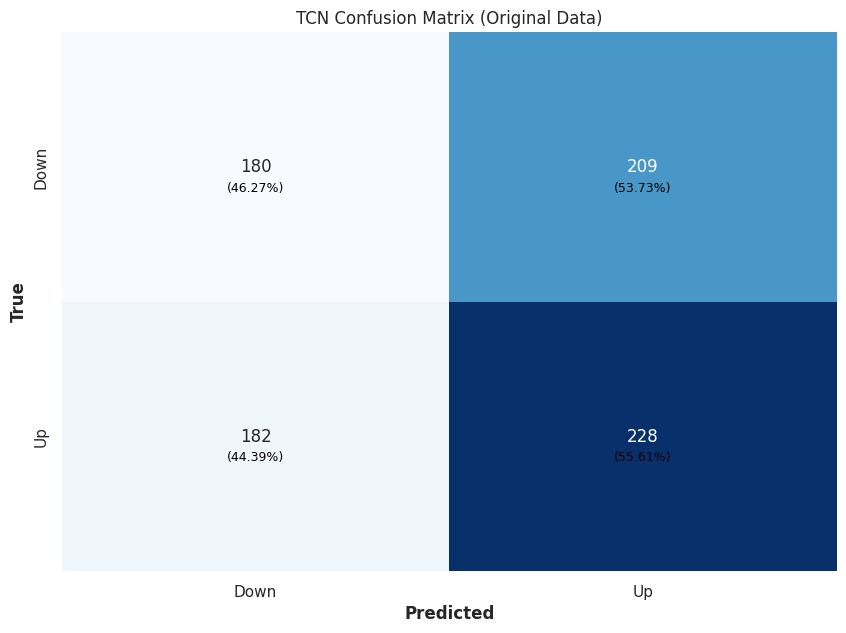

In [34]:
model = get_model_tcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Price Prediction Metrics:

TCN (Denoised) | MAE: 0.94
TCN (Denoised) | MSE: 1.84
TCN (Denoised) | RMSE: 1.36
TCN (Denoised) | RMSSE: 0.91
TCN (Denoised) | MAPE: 0.18%
TCN (Denoised) | MASE: 0.99
TCN (Denoised) | R2: 1.00


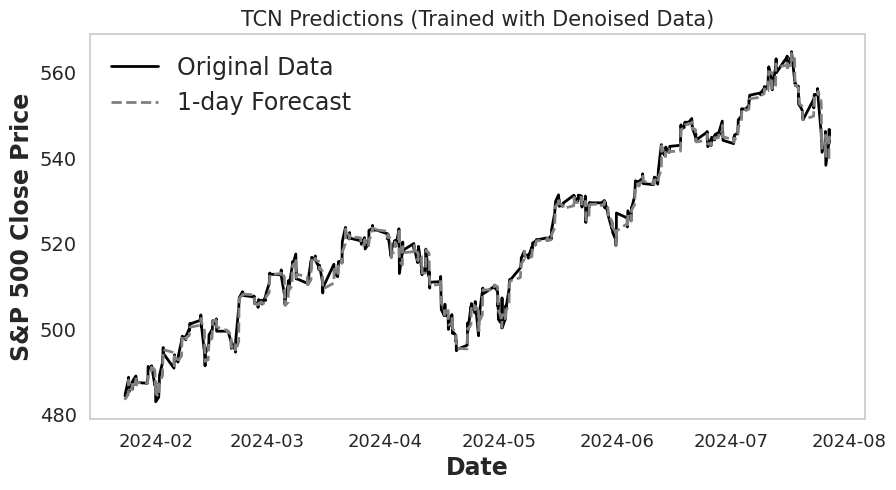

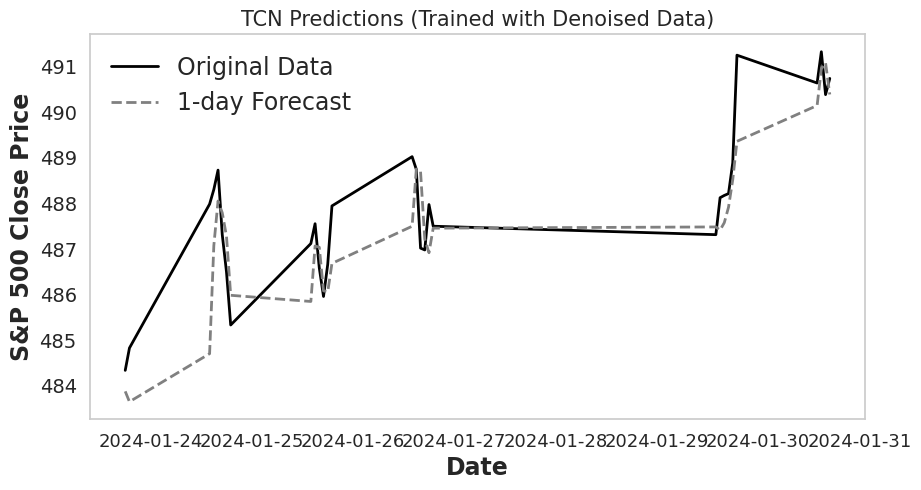


Directional Movement Metrics:

TCN (Denoised) | Train Accuracy: 64.80%
TCN (Denoised) | Validation Accuracy: 61.27%
TCN (Denoised) | Test Accuracy: 63.33%
TCN (Denoised) | Recall: 66.59%
TCN (Denoised) | Precision (Rise): 63.64%
TCN (Denoised) | Precision (Fall): 62.97%
TCN (Denoised) | F1 Score: 65.08%


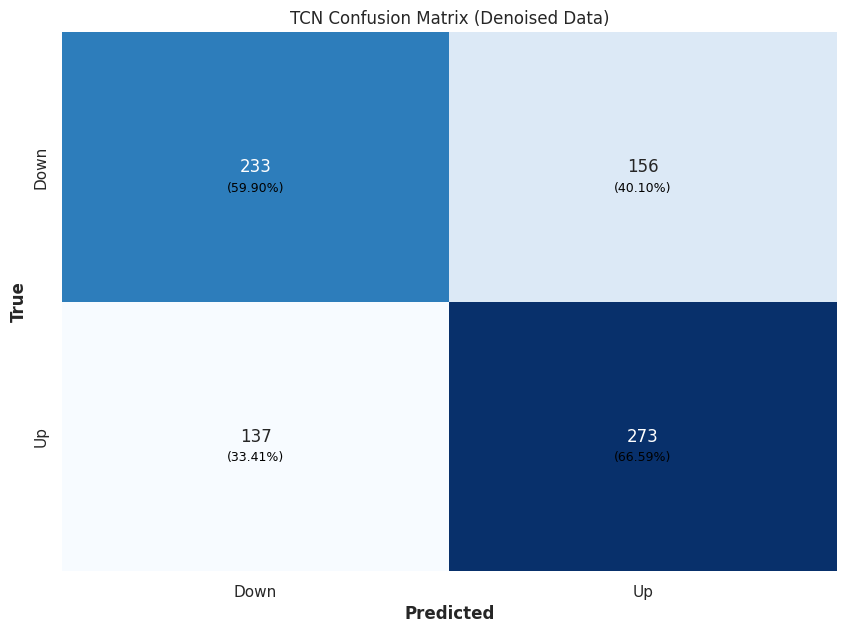

In [35]:
model = get_model_tcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### DeepTCN

**References**:

- Paper (2020): https://doi.org/10.48550/arXiv.1906.04397
- Code (same as TCN): https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/09-DeepTCN-examples.html

**Not denoised**

Price Prediction Metrics:

DeepTCN (Original) | MAE: 3.01
DeepTCN (Original) | MSE: 21.78
DeepTCN (Original) | RMSE: 4.67
DeepTCN (Original) | RMSSE: 3.14
DeepTCN (Original) | MAPE: 0.56%
DeepTCN (Original) | MASE: 3.17
DeepTCN (Original) | R2: 0.95


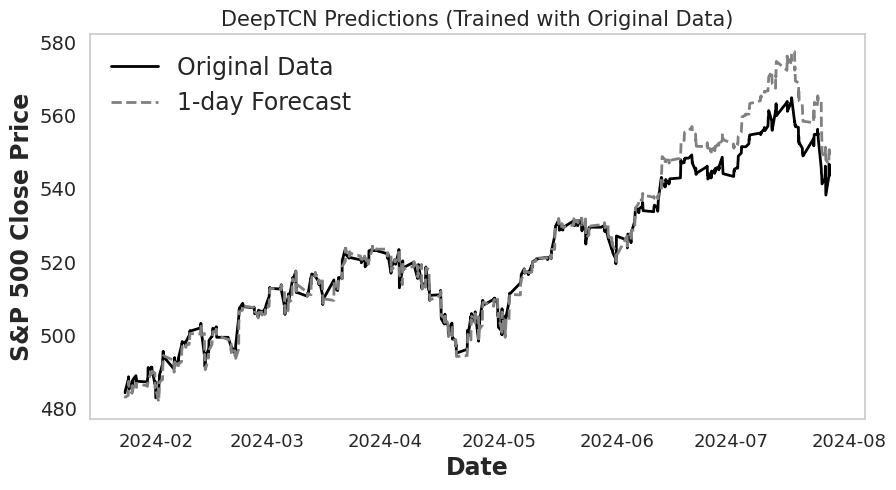

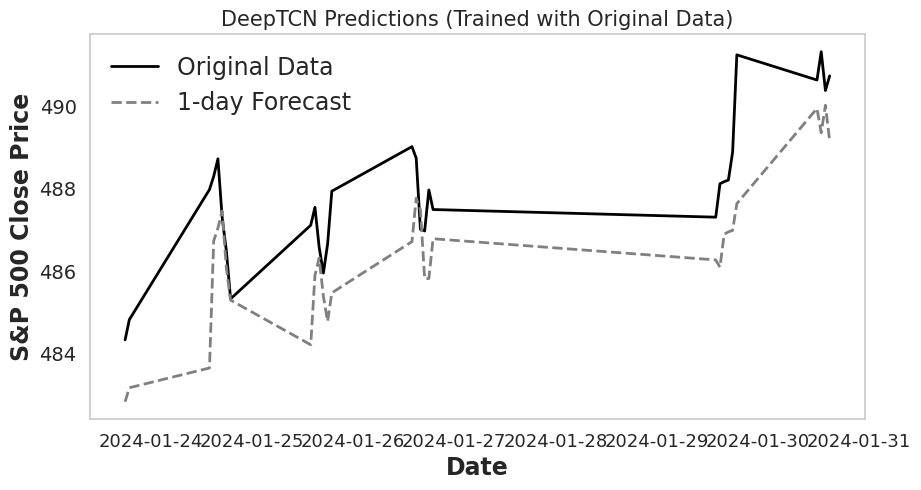


Directional Movement Metrics:

DeepTCN (Original) | Train Accuracy: 50.23%
DeepTCN (Original) | Validation Accuracy: 46.24%
DeepTCN (Original) | Test Accuracy: 50.19%
DeepTCN (Original) | Recall: 54.88%
DeepTCN (Original) | Precision (Rise): 51.37%
DeepTCN (Original) | Precision (Fall): 48.75%
DeepTCN (Original) | F1 Score: 53.07%


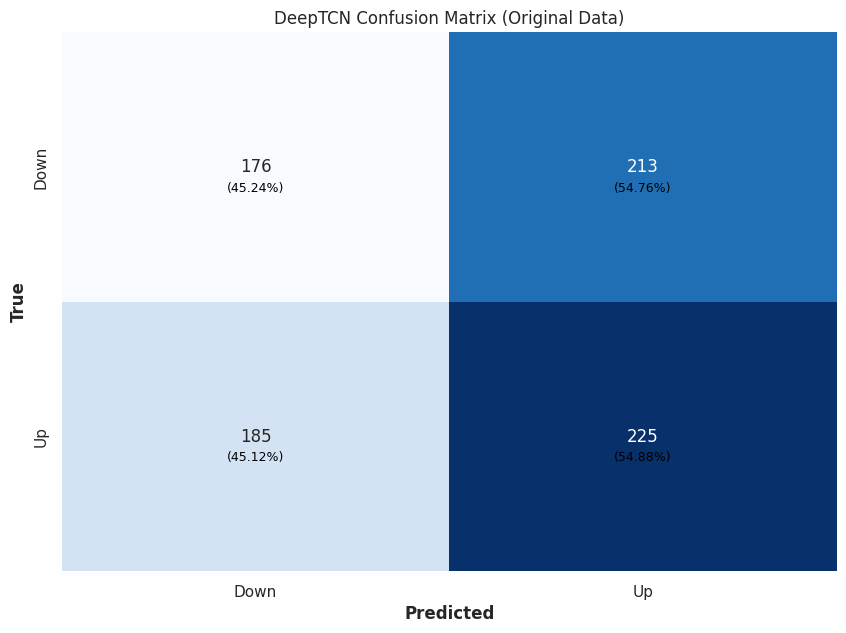

In [36]:
model = get_model_deeptcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Price Prediction Metrics:

DeepTCN (Denoised) | MAE: 2.52
DeepTCN (Denoised) | MSE: 14.00
DeepTCN (Denoised) | RMSE: 3.74
DeepTCN (Denoised) | RMSSE: 2.52
DeepTCN (Denoised) | MAPE: 0.47%
DeepTCN (Denoised) | MASE: 2.65
DeepTCN (Denoised) | R2: 0.97


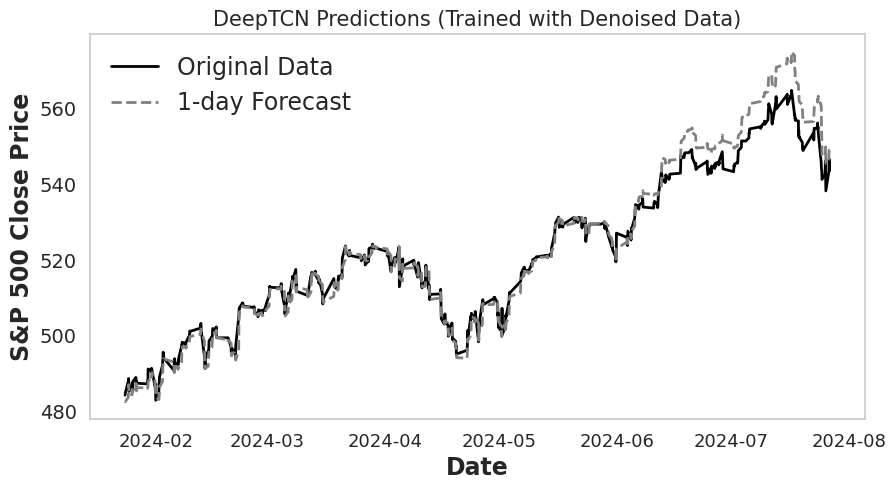

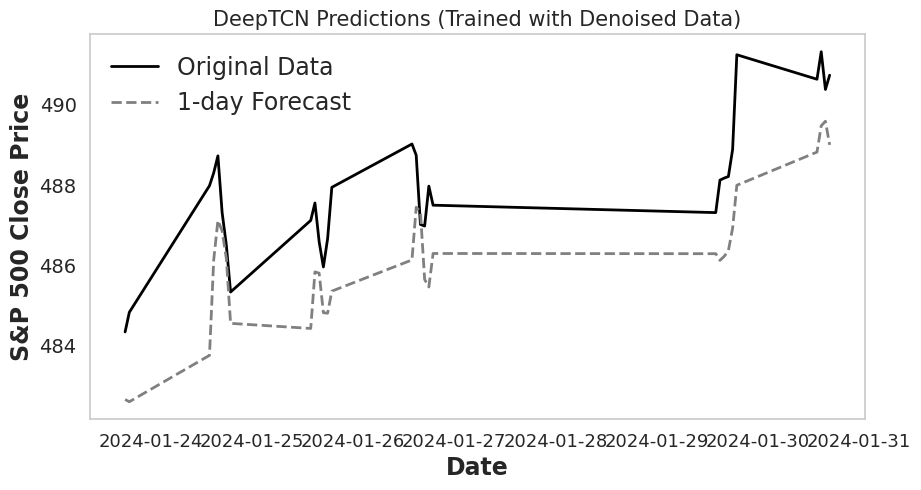


Directional Movement Metrics:

DeepTCN (Denoised) | Train Accuracy: 65.15%
DeepTCN (Denoised) | Validation Accuracy: 62.15%
DeepTCN (Denoised) | Test Accuracy: 62.08%
DeepTCN (Denoised) | Recall: 67.07%
DeepTCN (Denoised) | Precision (Rise): 62.08%
DeepTCN (Denoised) | Precision (Fall): 62.08%
DeepTCN (Denoised) | F1 Score: 64.48%


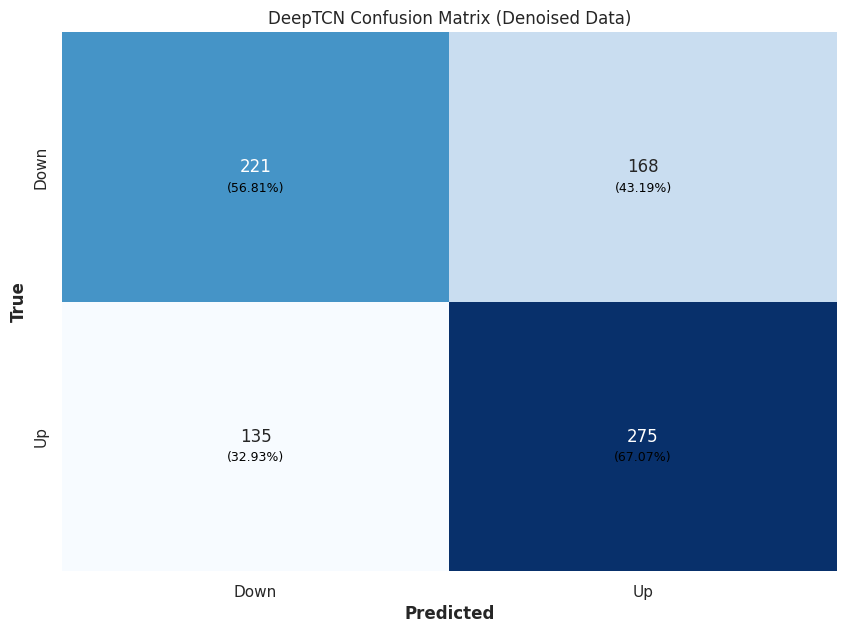

In [37]:
model = get_model_deeptcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-BEATS

**References**:
- Paper (2020): https://doi.org/10.48550/arXiv.1905.10437
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nbeats.py
- Darts documentation: https://unit8co.github.io/darts/examples/07-NBEATS-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Original) | MAE: 1.53
N-BEATS (Original) | MSE: 4.48
N-BEATS (Original) | RMSE: 2.12
N-BEATS (Original) | RMSSE: 1.43
N-BEATS (Original) | MAPE: 0.29%
N-BEATS (Original) | MASE: 1.61
N-BEATS (Original) | R2: 0.99


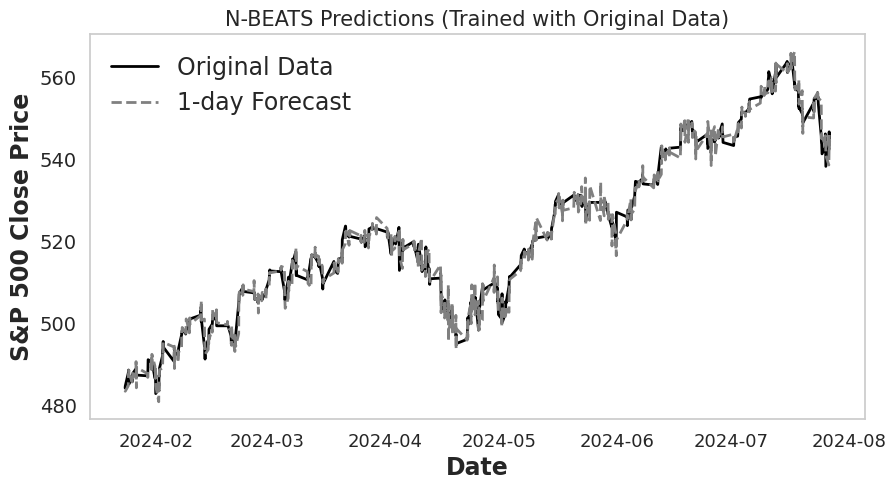

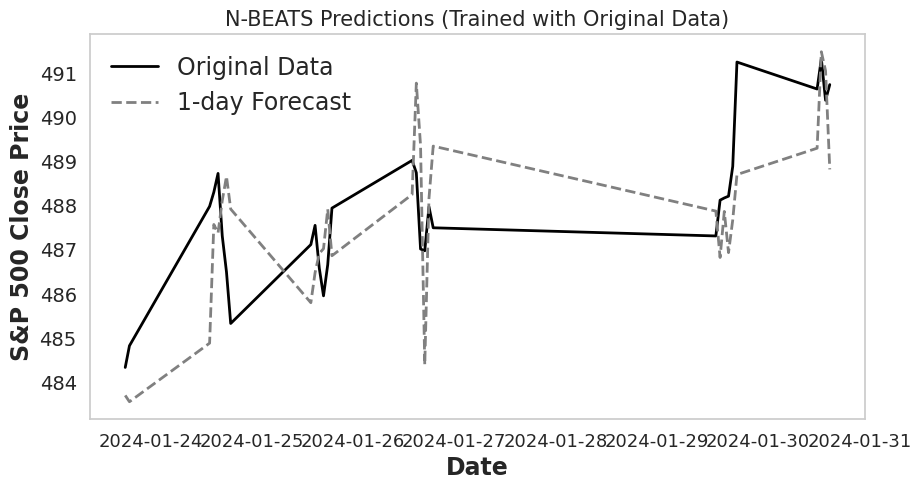


Directional Movement Metrics:

N-BEATS (Original) | Train Accuracy: 52.45%
N-BEATS (Original) | Validation Accuracy: 51.69%
N-BEATS (Original) | Test Accuracy: 52.32%
N-BEATS (Original) | Recall: 54.39%
N-BEATS (Original) | Precision (Rise): 53.48%
N-BEATS (Original) | Precision (Fall): 51.05%
N-BEATS (Original) | F1 Score: 53.93%


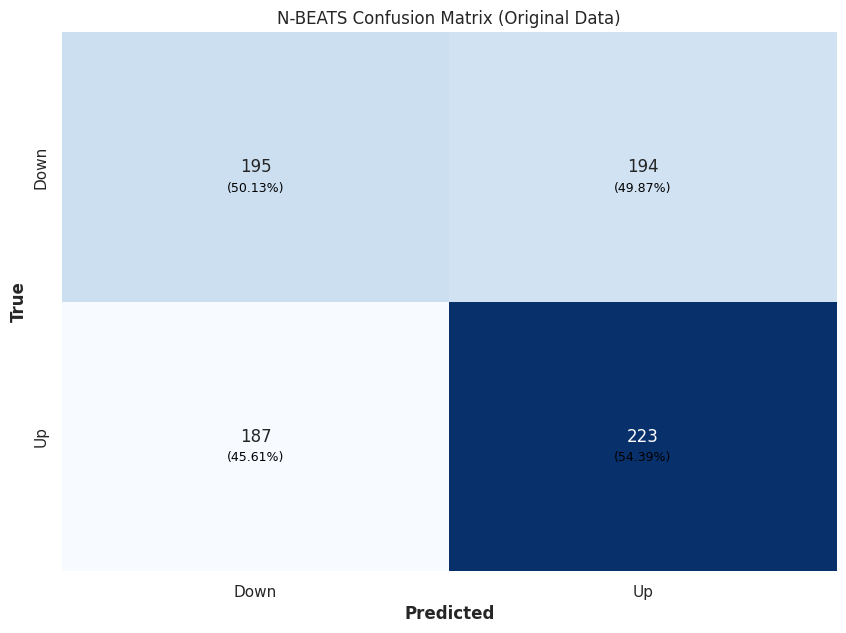

In [38]:
model = get_model_nbeats()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Denoised) | MAE: 1.18
N-BEATS (Denoised) | MSE: 2.60
N-BEATS (Denoised) | RMSE: 1.61
N-BEATS (Denoised) | RMSSE: 1.09
N-BEATS (Denoised) | MAPE: 0.23%
N-BEATS (Denoised) | MASE: 1.24
N-BEATS (Denoised) | R2: 0.99


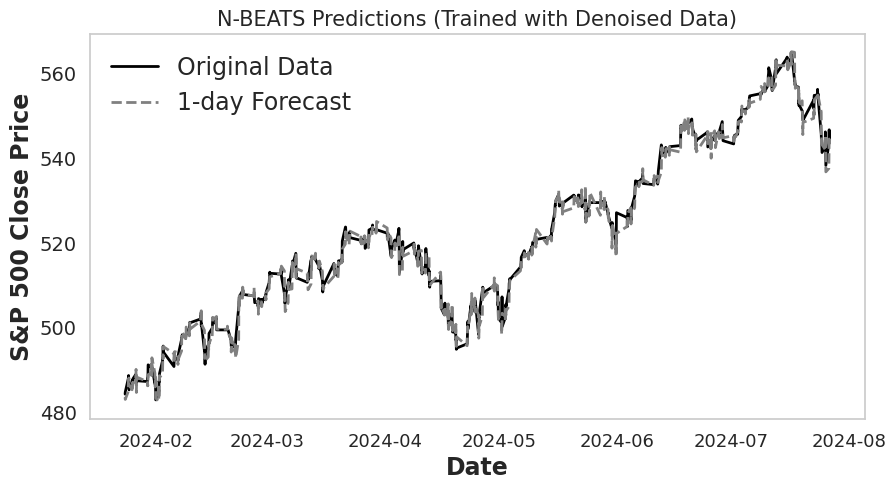

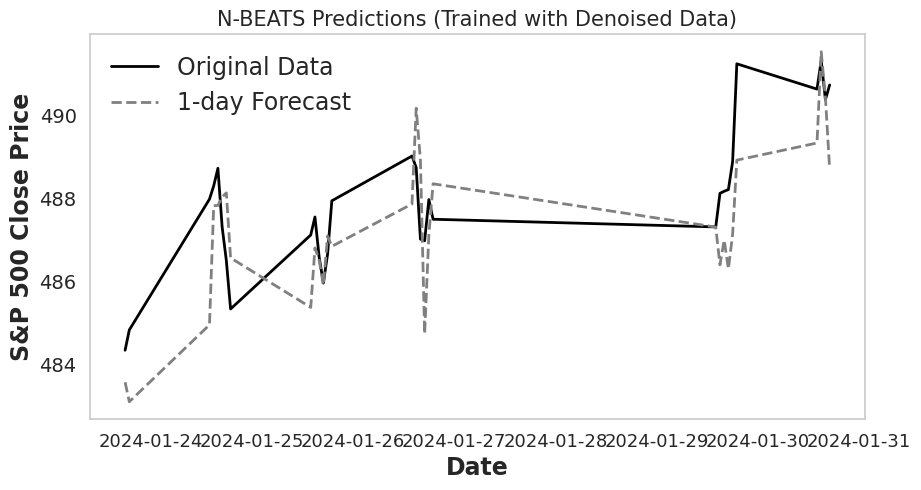


Directional Movement Metrics:

N-BEATS (Denoised) | Train Accuracy: 60.67%
N-BEATS (Denoised) | Validation Accuracy: 58.17%
N-BEATS (Denoised) | Test Accuracy: 58.45%
N-BEATS (Denoised) | Recall: 62.20%
N-BEATS (Denoised) | Precision (Rise): 59.03%
N-BEATS (Denoised) | Precision (Fall): 57.77%
N-BEATS (Denoised) | F1 Score: 60.57%


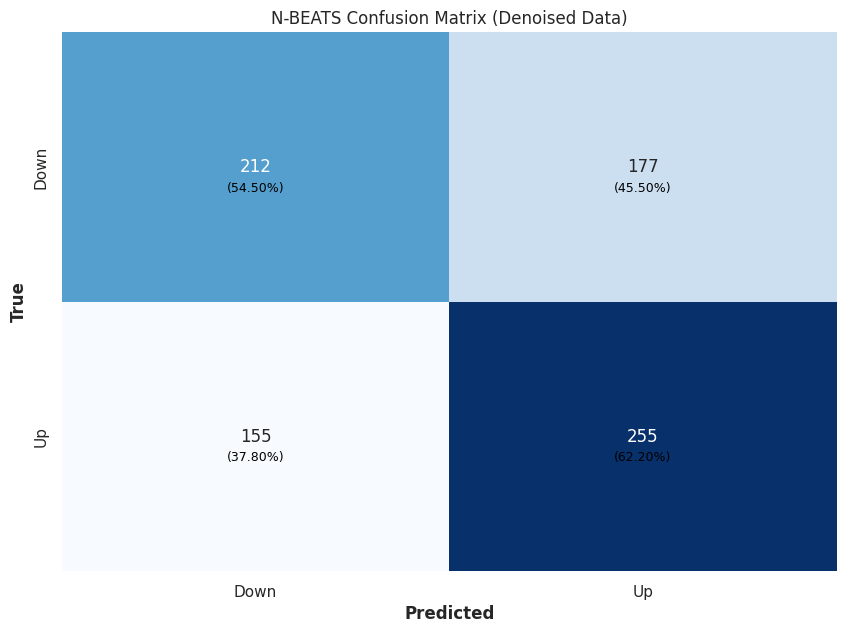

In [39]:
model = get_model_nbeats()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TFT

Temporal Fusion Transformer Model

**References**:

- Paper (2021): https://doi.org/10.1016/j.ijforecast.2021.03.012
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tft_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/13-TFT-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Original) | MAE: 2.65
TFT (Original) | MSE: 15.01
TFT (Original) | RMSE: 3.87
TFT (Original) | RMSSE: 2.61
TFT (Original) | MAPE: 0.51%
TFT (Original) | MASE: 2.79
TFT (Original) | R2: 0.96


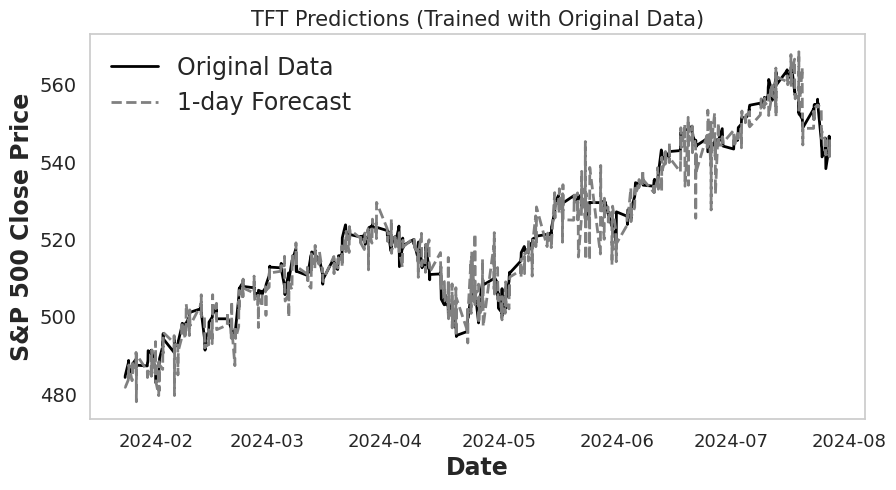

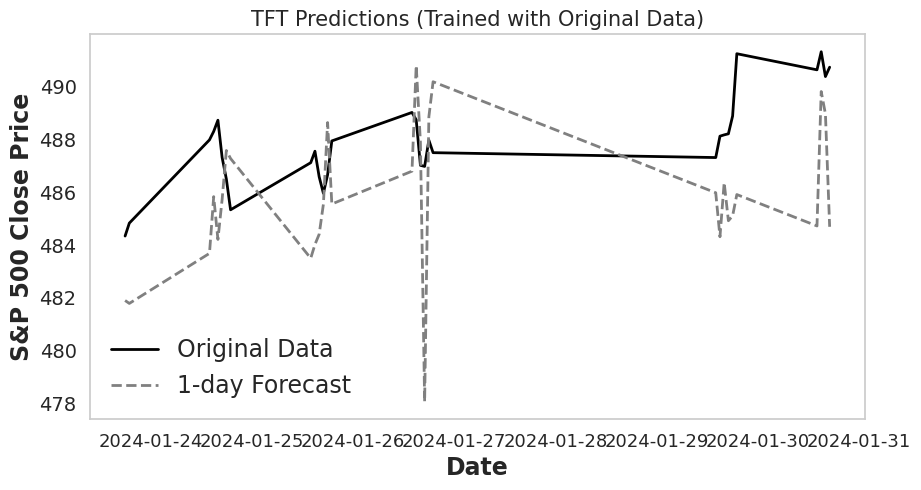


Directional Movement Metrics:

TFT (Original) | Train Accuracy: 50.77%
TFT (Original) | Validation Accuracy: 50.52%
TFT (Original) | Test Accuracy: 52.07%
TFT (Original) | Recall: 52.93%
TFT (Original) | Precision (Rise): 53.32%
TFT (Original) | Precision (Fall): 50.77%
TFT (Original) | F1 Score: 53.12%


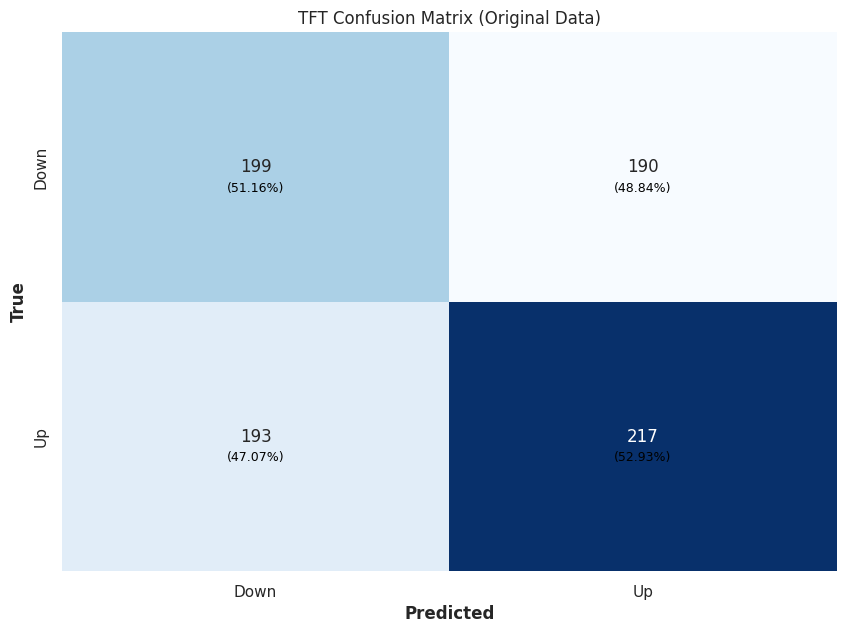

In [40]:
model = get_model_tft()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Denoised) | MAE: 2.42
TFT (Denoised) | MSE: 12.97
TFT (Denoised) | RMSE: 3.60
TFT (Denoised) | RMSSE: 2.42
TFT (Denoised) | MAPE: 0.46%
TFT (Denoised) | MASE: 2.55
TFT (Denoised) | R2: 0.97


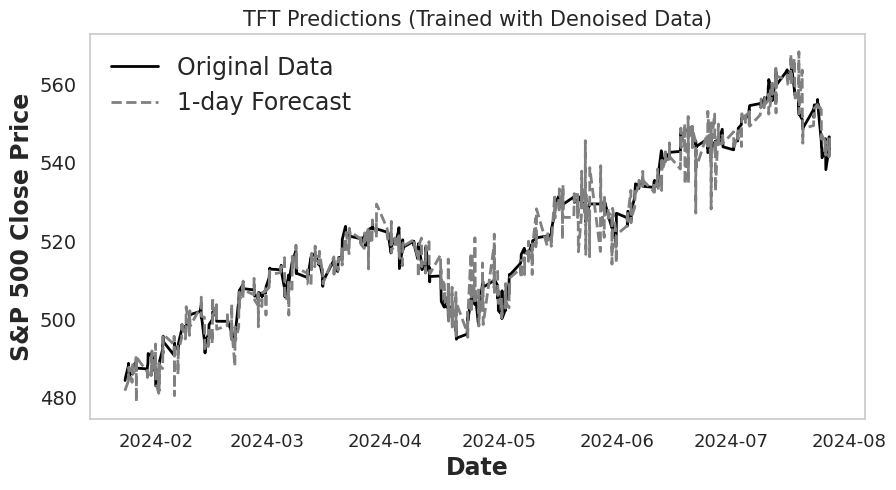

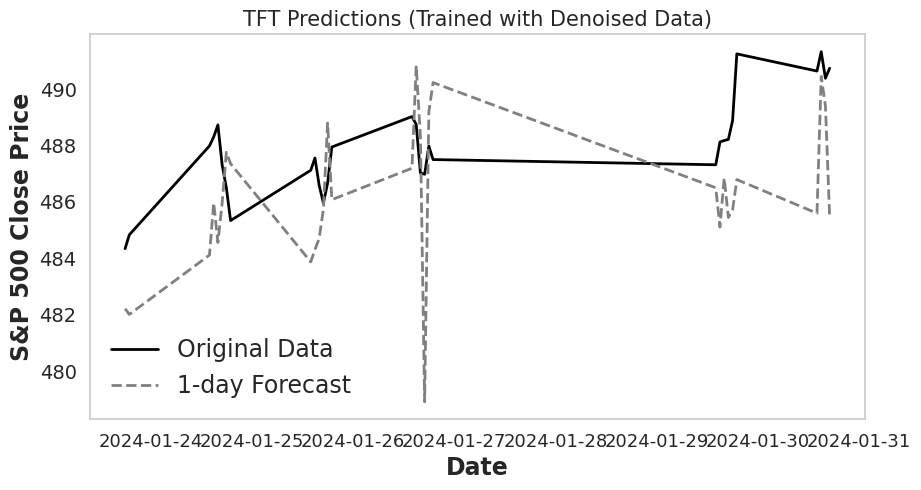


Directional Movement Metrics:

TFT (Denoised) | Train Accuracy: 53.17%
TFT (Denoised) | Validation Accuracy: 51.40%
TFT (Denoised) | Test Accuracy: 52.94%
TFT (Denoised) | Recall: 54.39%
TFT (Denoised) | Precision (Rise): 54.13%
TFT (Denoised) | Precision (Fall): 51.68%
TFT (Denoised) | F1 Score: 54.26%


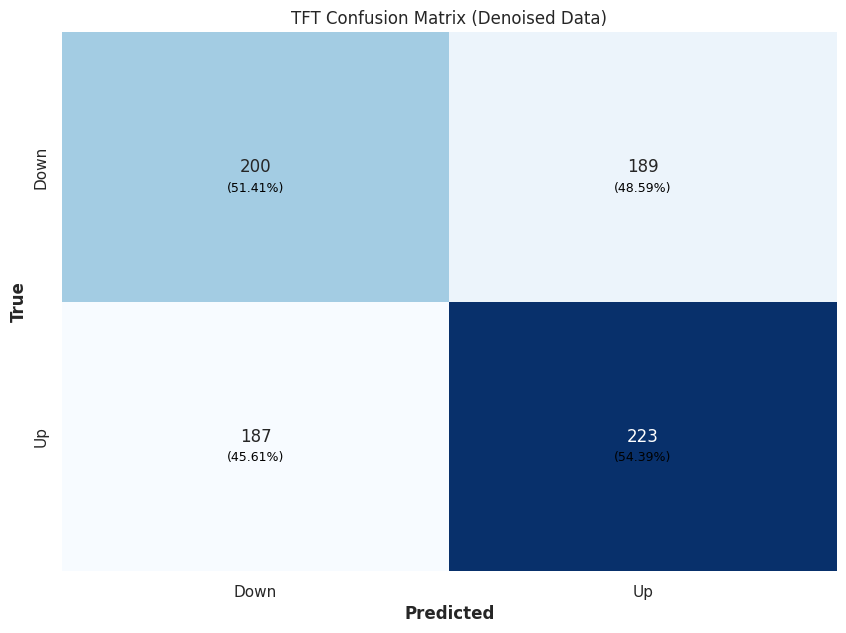

In [41]:
model = get_model_tft()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TiDE

TimeSeries Dense Encoder Model

**References**:
- Paper (2024): https://doi.org/10.48550/arXiv.2304.08424
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tide_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**+RIN**

Reversible Instance Normalization for Accurate Time-Series Forecasting against Distribution Shift

- Paper: https://openreview.net/forum?id=cGDAkQo1C0p

**Not denoised**

Price Prediction Metrics:

TiDE (Original) | MAE: 1.06
TiDE (Original) | MSE: 2.41
TiDE (Original) | RMSE: 1.55
TiDE (Original) | RMSSE: 1.05
TiDE (Original) | MAPE: 0.20%
TiDE (Original) | MASE: 1.11
TiDE (Original) | R2: 0.99


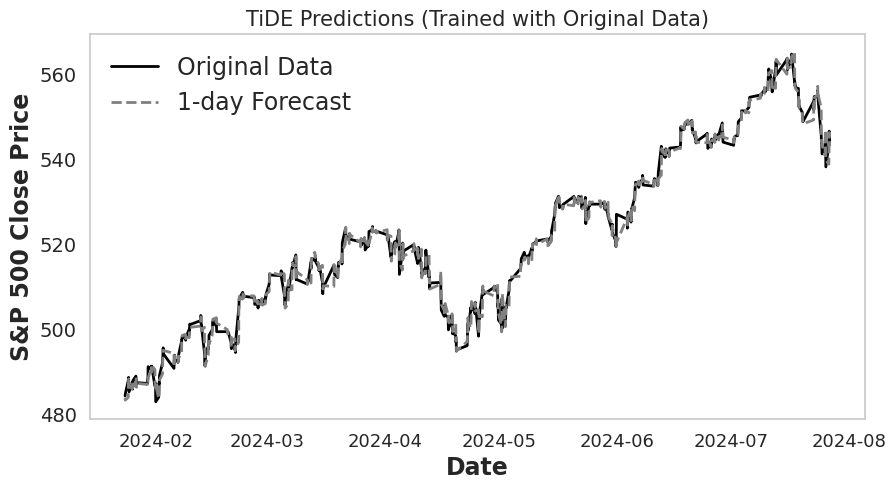

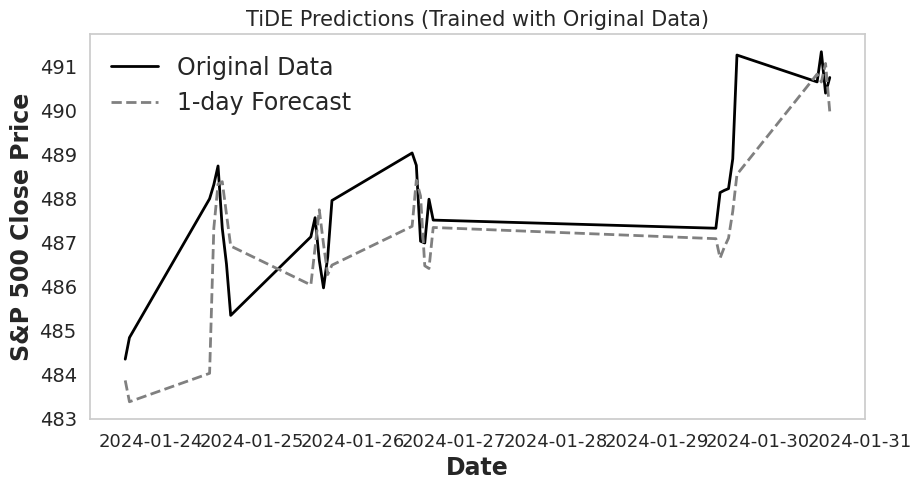


Directional Movement Metrics:

TiDE (Original) | Train Accuracy: 55.71%
TiDE (Original) | Validation Accuracy: 48.90%
TiDE (Original) | Test Accuracy: 52.32%
TiDE (Original) | Recall: 55.12%
TiDE (Original) | Precision (Rise): 53.43%
TiDE (Original) | Precision (Fall): 51.06%
TiDE (Original) | F1 Score: 54.26%


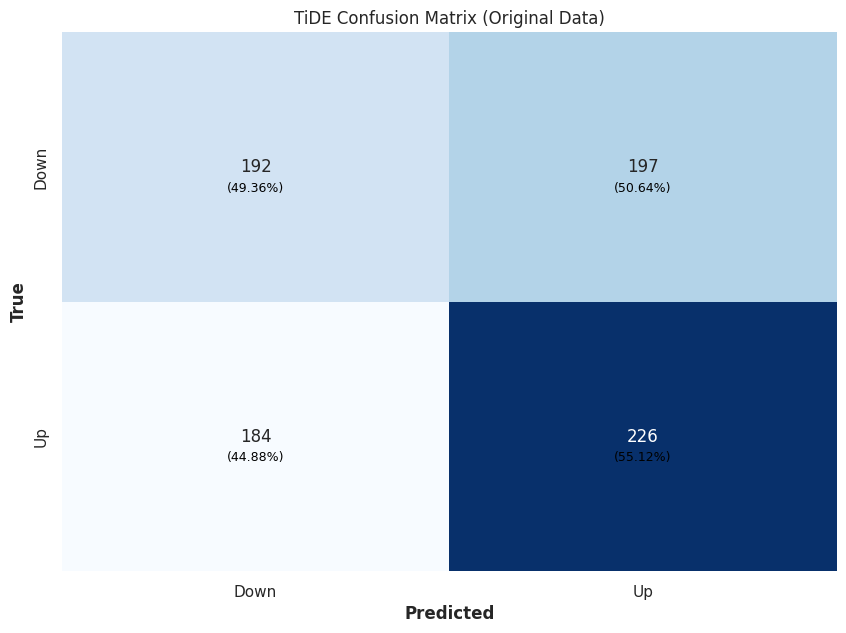

In [42]:
model = get_model_tide()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Price Prediction Metrics:

TiDE (Denoised) | MAE: 0.83
TiDE (Denoised) | MSE: 1.40
TiDE (Denoised) | RMSE: 1.18
TiDE (Denoised) | RMSSE: 0.80
TiDE (Denoised) | MAPE: 0.16%
TiDE (Denoised) | MASE: 0.87
TiDE (Denoised) | R2: 1.00


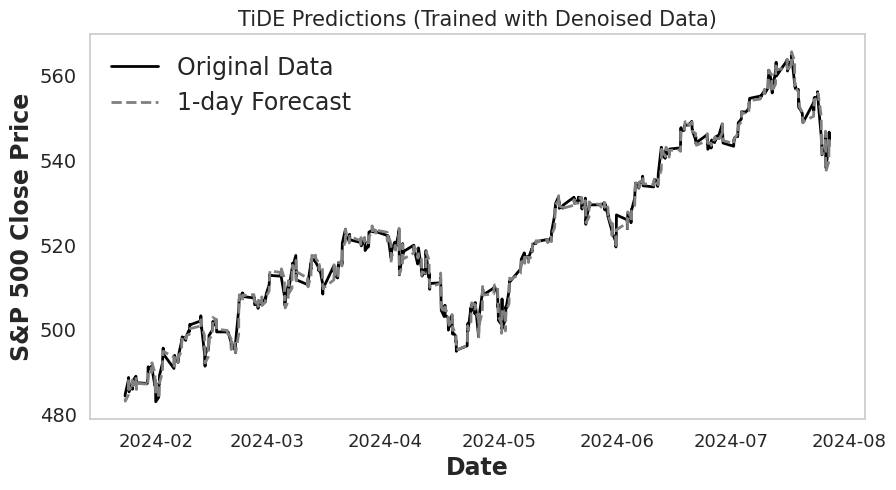

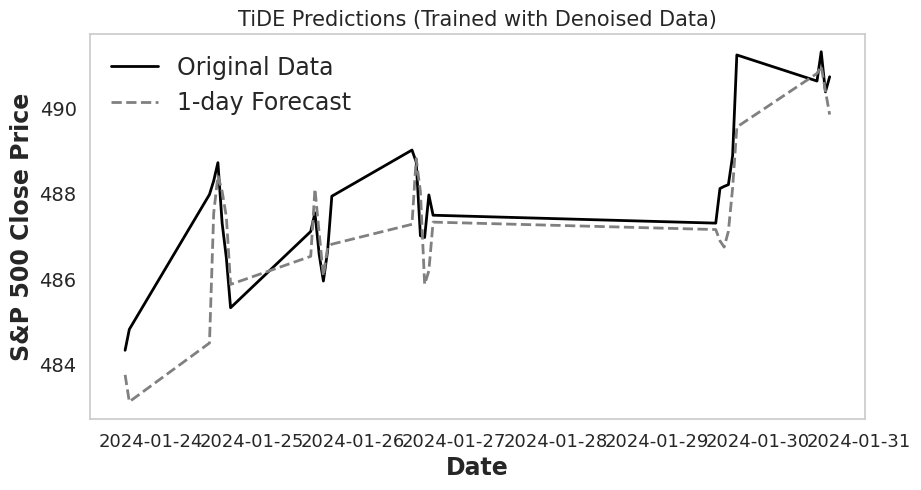


Directional Movement Metrics:

TiDE (Denoised) | Train Accuracy: 66.91%
TiDE (Denoised) | Validation Accuracy: 63.77%
TiDE (Denoised) | Test Accuracy: 65.21%
TiDE (Denoised) | Recall: 69.27%
TiDE (Denoised) | Precision (Rise): 65.14%
TiDE (Denoised) | Precision (Fall): 65.29%
TiDE (Denoised) | F1 Score: 67.14%


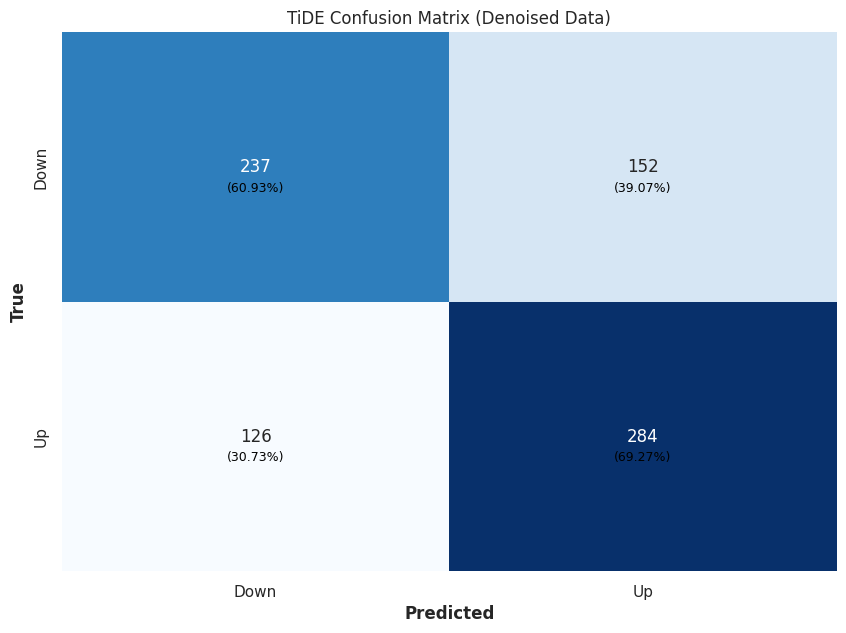

In [43]:
model = get_model_tide()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-HiTS

**Neural Hierarchical Interpolation for Time Series Forecasting**

References:

- Paper (2022): https://doi.org/10.48550/arXiv.2201.12886
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nhits.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Original) | MAE: 1.61
N-HiTS (Original) | MSE: 4.79
N-HiTS (Original) | RMSE: 2.19
N-HiTS (Original) | RMSSE: 1.47
N-HiTS (Original) | MAPE: 0.31%
N-HiTS (Original) | MASE: 1.70
N-HiTS (Original) | R2: 0.99


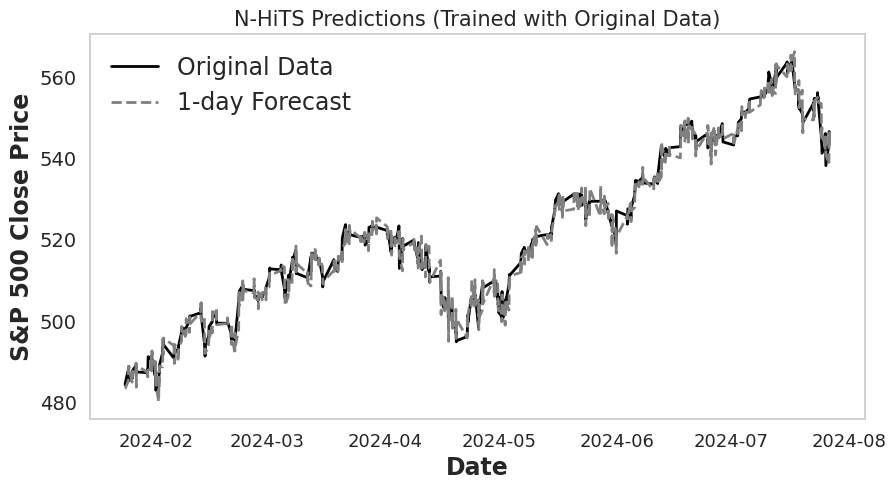

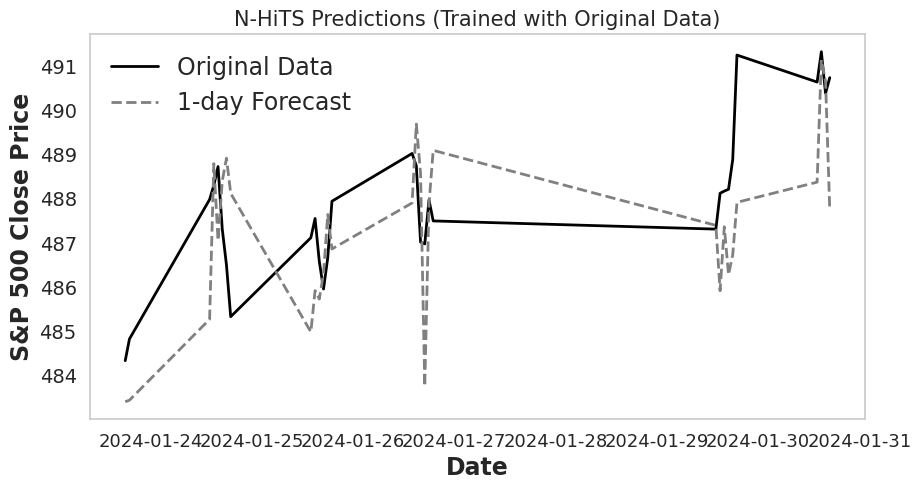


Directional Movement Metrics:

N-HiTS (Original) | Train Accuracy: 51.03%
N-HiTS (Original) | Validation Accuracy: 51.10%
N-HiTS (Original) | Test Accuracy: 51.81%
N-HiTS (Original) | Recall: 53.17%
N-HiTS (Original) | Precision (Rise): 53.04%
N-HiTS (Original) | Precision (Fall): 50.52%
N-HiTS (Original) | F1 Score: 53.11%


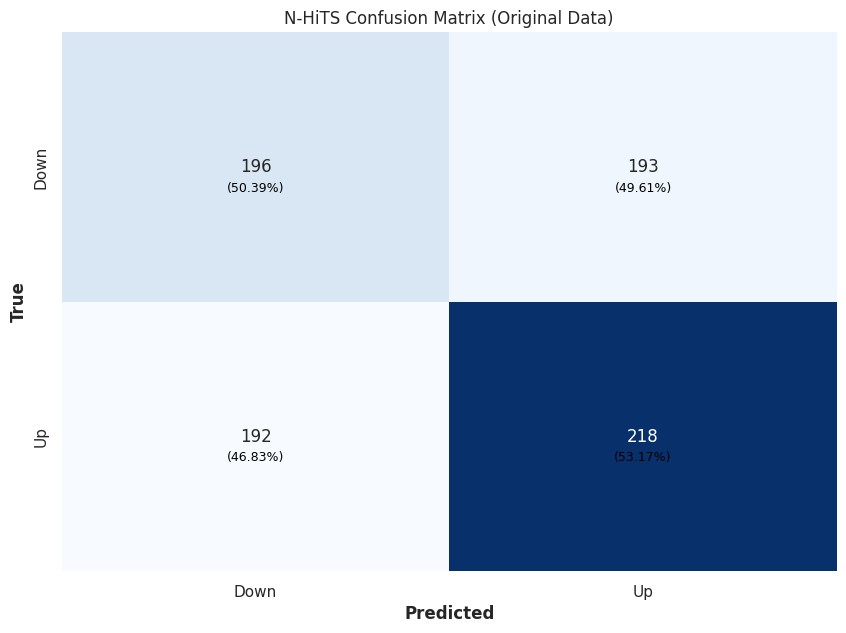

In [44]:
model = get_model_nhits()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Denoised) | MAE: 1.38
N-HiTS (Denoised) | MSE: 3.36
N-HiTS (Denoised) | RMSE: 1.83
N-HiTS (Denoised) | RMSSE: 1.23
N-HiTS (Denoised) | MAPE: 0.26%
N-HiTS (Denoised) | MASE: 1.45
N-HiTS (Denoised) | R2: 0.99


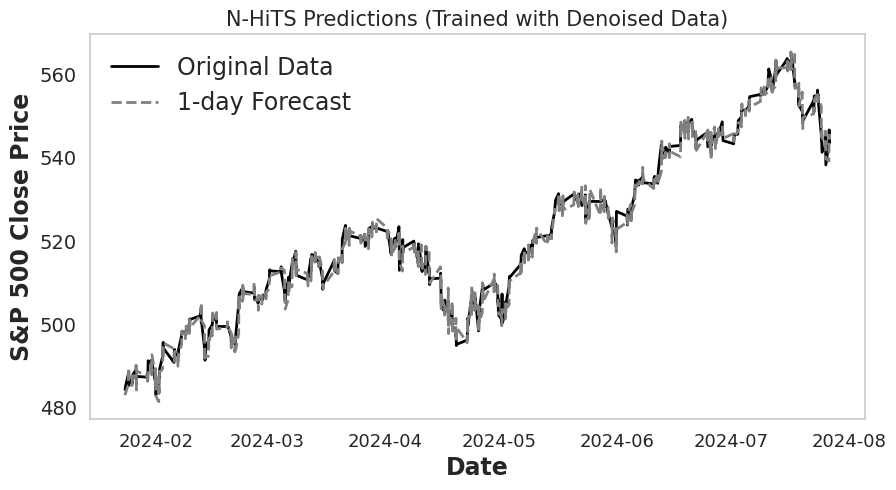

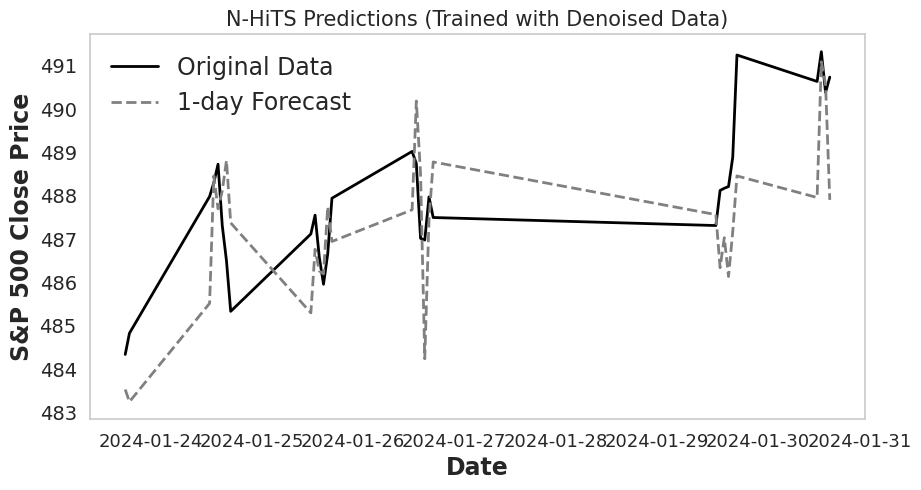


Directional Movement Metrics:

N-HiTS (Denoised) | Train Accuracy: 57.17%
N-HiTS (Denoised) | Validation Accuracy: 55.82%
N-HiTS (Denoised) | Test Accuracy: 55.82%
N-HiTS (Denoised) | Recall: 58.54%
N-HiTS (Denoised) | Precision (Rise): 56.74%
N-HiTS (Denoised) | Precision (Fall): 54.79%
N-HiTS (Denoised) | F1 Score: 57.62%


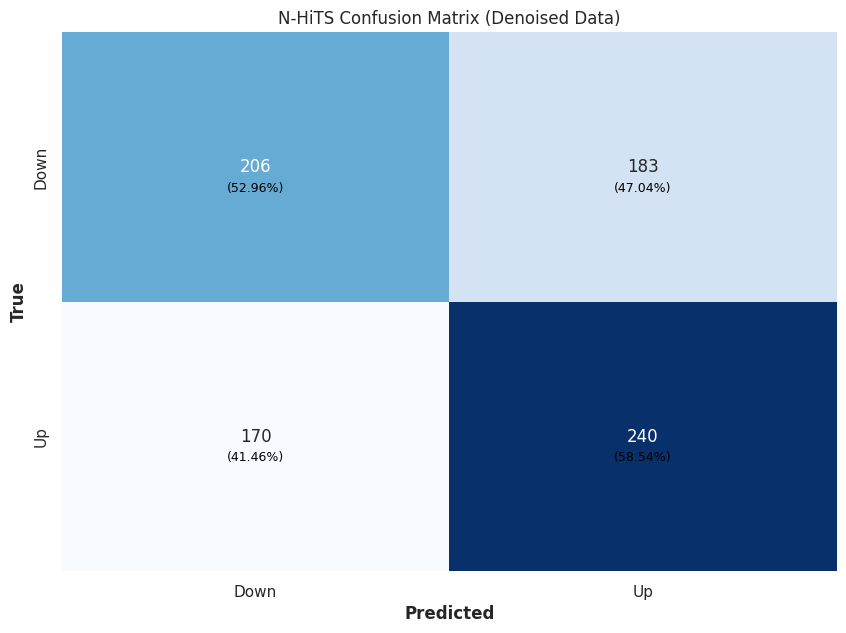

In [45]:
model = get_model_nhits()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TSMixer

TimeSeries Mixer Model

**References**:
- Paper (2023): https://doi.org/10.48550/arXiv.2303.06053
- Code: https://github.com/ditschuk/pytorch-tsmixer
- Darts documentation: https://unit8co.github.io/darts/examples/21-TSMixer-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Original) | MAE: 3.79
TSMixer (Original) | MSE: 26.55
TSMixer (Original) | RMSE: 5.15
TSMixer (Original) | RMSSE: 3.47
TSMixer (Original) | MAPE: 0.73%
TSMixer (Original) | MASE: 3.99
TSMixer (Original) | R2: 0.93


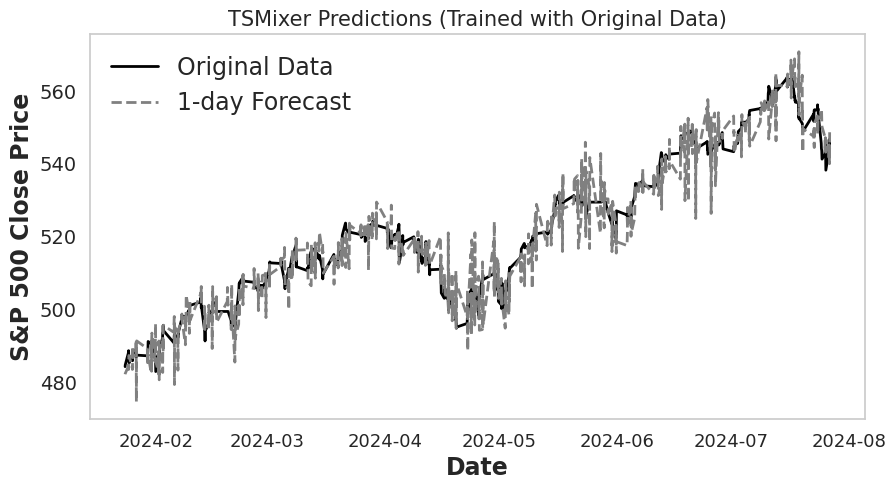

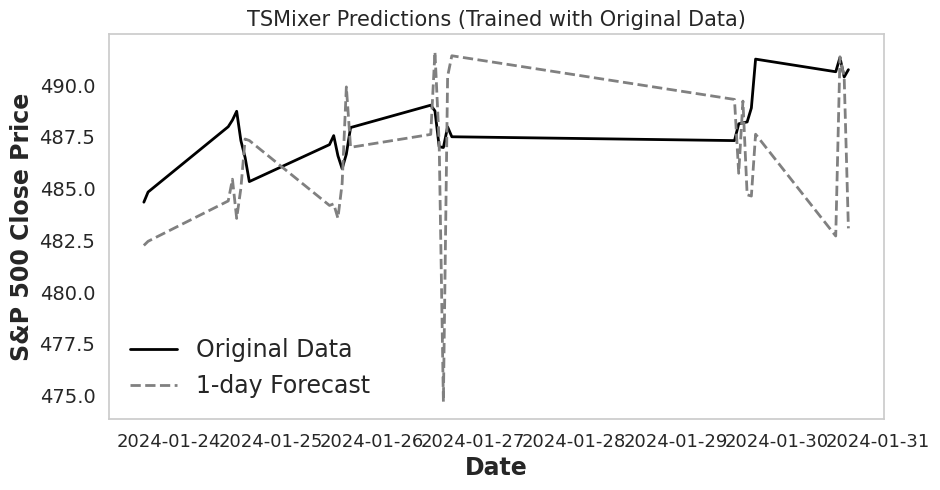


Directional Movement Metrics:

TSMixer (Original) | Train Accuracy: 50.25%
TSMixer (Original) | Validation Accuracy: 52.58%
TSMixer (Original) | Test Accuracy: 51.94%
TSMixer (Original) | Recall: 51.71%
TSMixer (Original) | Precision (Rise): 53.27%
TSMixer (Original) | Precision (Fall): 50.62%
TSMixer (Original) | F1 Score: 52.48%


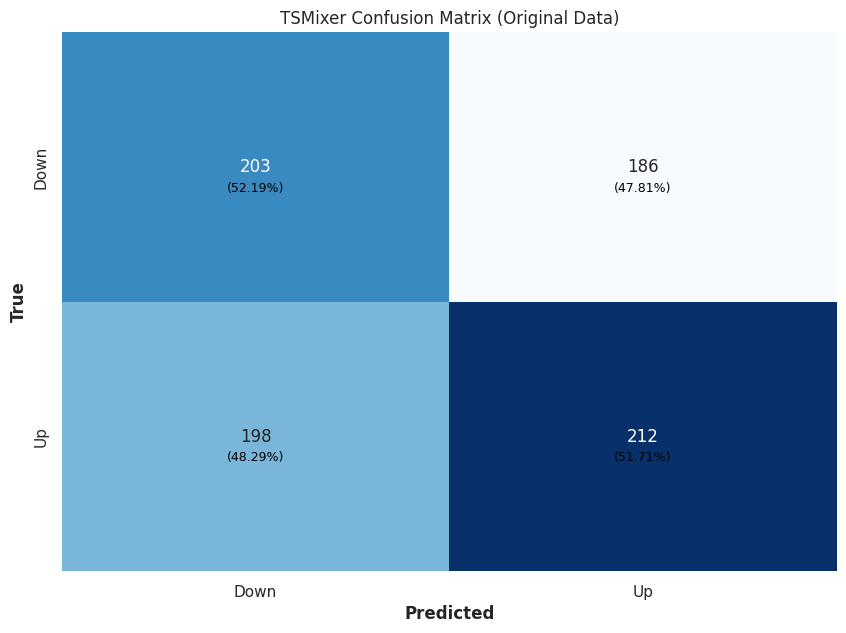

In [46]:
model = get_model_tsm()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Denoised) | MAE: 3.68
TSMixer (Denoised) | MSE: 25.26
TSMixer (Denoised) | RMSE: 5.03
TSMixer (Denoised) | RMSSE: 3.38
TSMixer (Denoised) | MAPE: 0.71%
TSMixer (Denoised) | MASE: 3.88
TSMixer (Denoised) | R2: 0.94


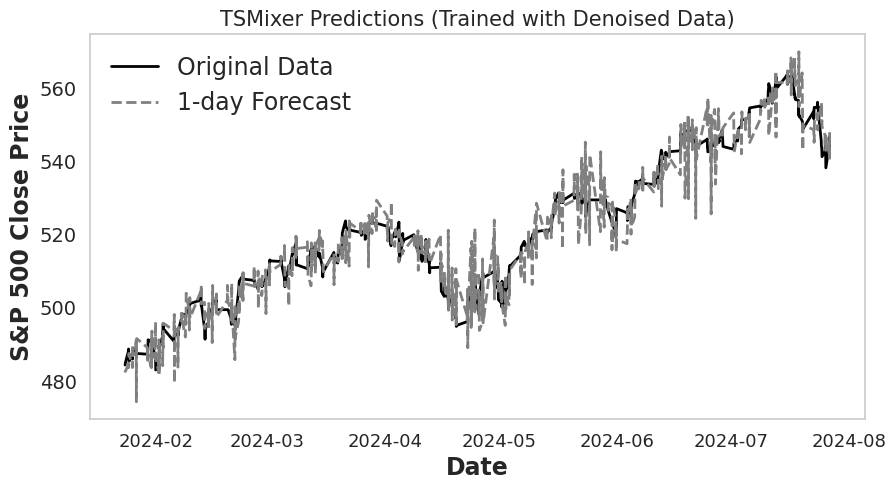

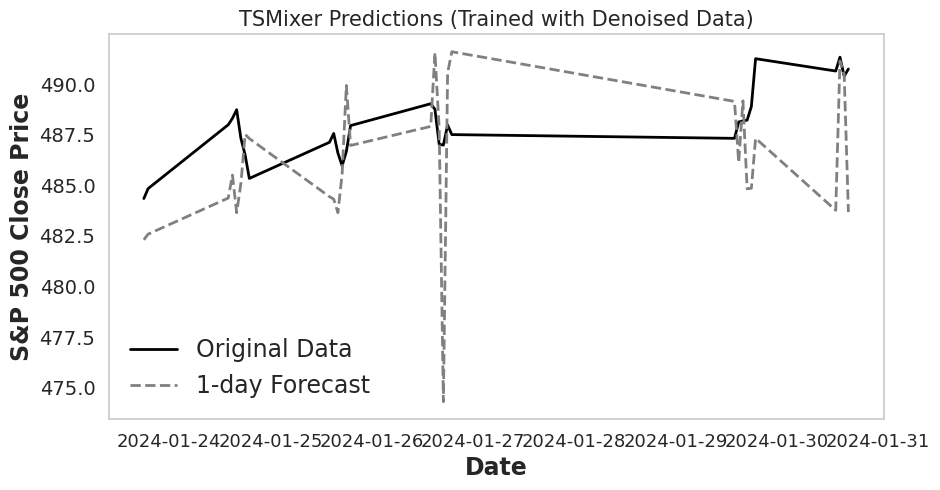


Directional Movement Metrics:

TSMixer (Denoised) | Train Accuracy: 50.66%
TSMixer (Denoised) | Validation Accuracy: 51.84%
TSMixer (Denoised) | Test Accuracy: 51.69%
TSMixer (Denoised) | Recall: 51.71%
TSMixer (Denoised) | Precision (Rise): 53.00%
TSMixer (Denoised) | Precision (Fall): 50.38%
TSMixer (Denoised) | F1 Score: 52.35%


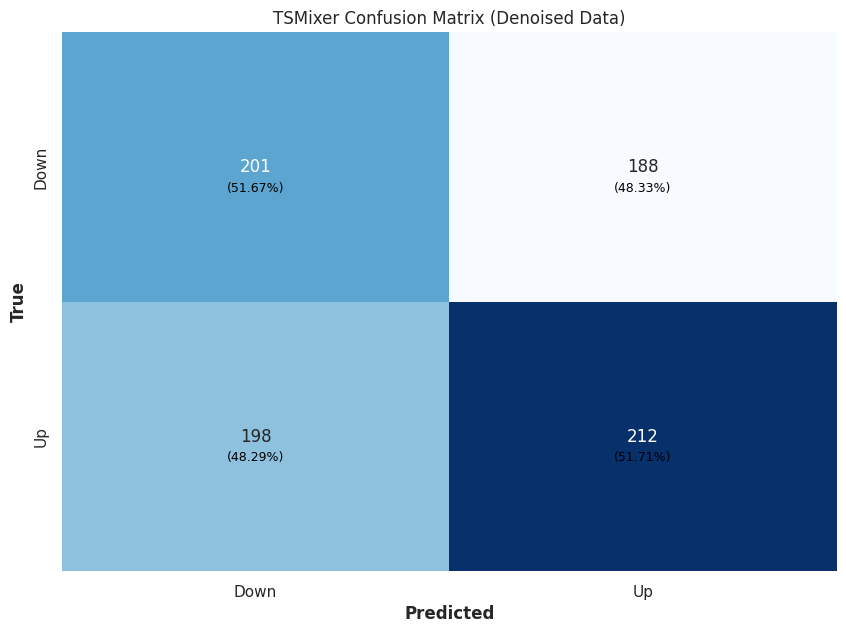

In [47]:
model = get_model_tsm()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### New proposed model: xLSTM-TS, a time series-specific implementation

**References:**

- Paper (2024): https://doi.org/10.48550/arXiv.2405.04517

- Official code: https://github.com/NX-AI/xlstm

- Parameters for time series: https://github.com/smvorwerk/xlstm-cuda

#### Configuration

#### Training and evaluation

In [49]:
from ml.xlstm_ts.model import *

In [50]:
plot_architecture_xlstm()

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


In [51]:
model_name = 'xLSTM-TS'

**Not denoised**

Epoch [1/200], Loss: 0.00051502, Validation Loss: 0.00033827
Epoch [2/200], Loss: 0.00007689, Validation Loss: 0.00004620
Epoch [3/200], Loss: 0.00011481, Validation Loss: 0.00006854
Epoch [4/200], Loss: 0.00000624, Validation Loss: 0.00003148
Epoch [5/200], Loss: 0.00018721, Validation Loss: 0.00019558
Epoch [6/200], Loss: 0.00000732, Validation Loss: 0.00003175
Epoch [7/200], Loss: 0.00009820, Validation Loss: 0.00009918
Epoch [8/200], Loss: 0.00011331, Validation Loss: 0.00010099
Epoch [9/200], Loss: 0.00001804, Validation Loss: 0.00003161
Epoch [10/200], Loss: 0.00003326, Validation Loss: 0.00003446
Epoch [11/200], Loss: 0.00001275, Validation Loss: 0.00004890
Epoch [12/200], Loss: 0.00004492, Validation Loss: 0.00005619
Epoch [13/200], Loss: 0.00007085, Validation Loss: 0.00006195
Epoch [14/200], Loss: 0.00020860, Validation Loss: 0.00020465
Epoch [15/200], Reducing learning rate to 5e-05
Epoch [15/200], Loss: 0.00015985, Validation Loss: 0.00012389
Epoch [16/200], Loss: 0.0000232

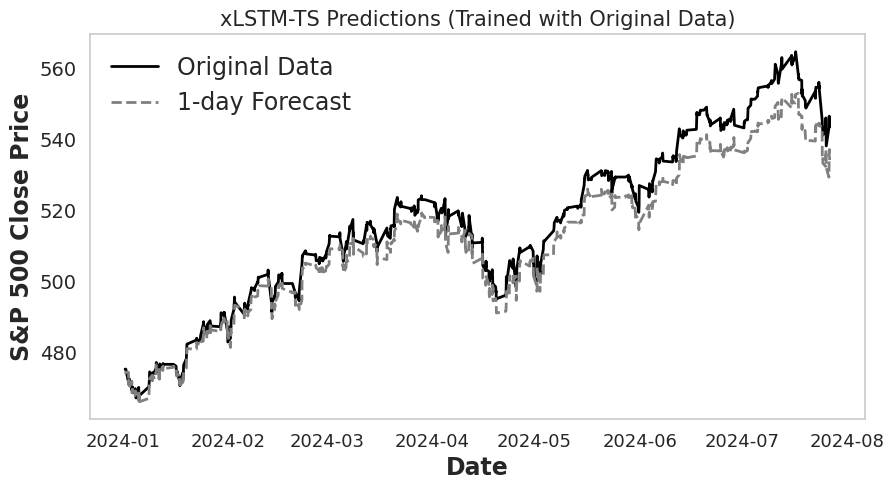

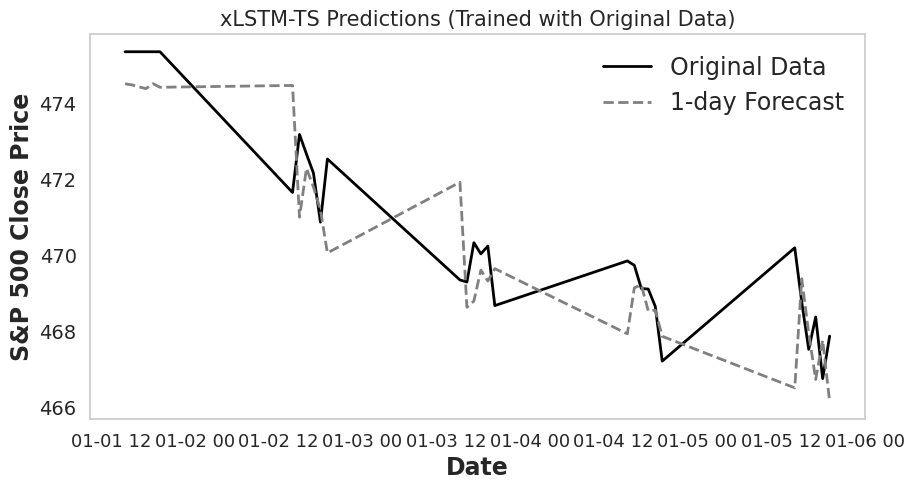

xLSTM-TS (Original) | Train Accuracy: 50.82%
xLSTM-TS (Original) | Validation Accuracy: 46.73%
xLSTM-TS (Original) | Test Accuracy: 49.61%
xLSTM-TS (Original) | Recall: 53.36%
xLSTM-TS (Original) | Precision (Rise): 50.83%
xLSTM-TS (Original) | Precision (Fall): 48.19%
xLSTM-TS (Original) | F1 Score: 52.06%


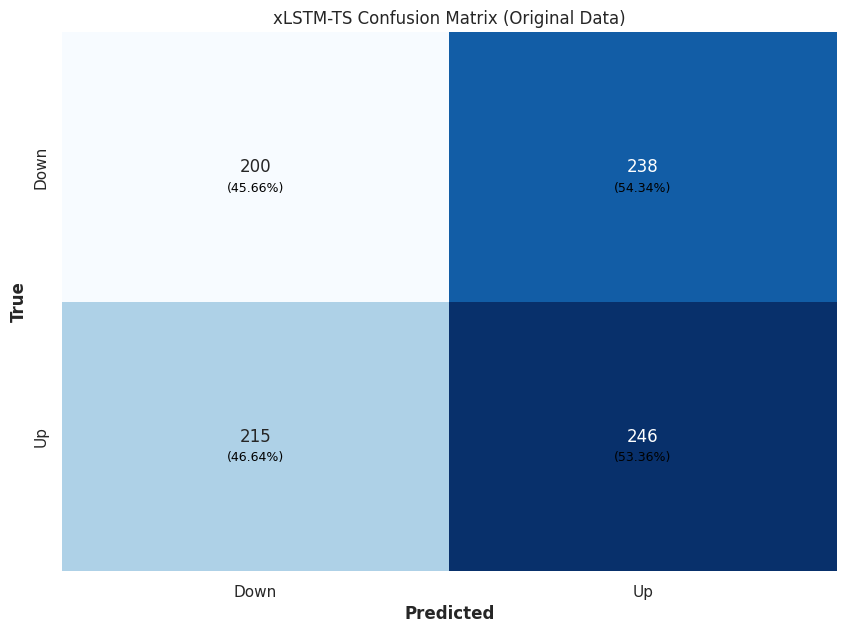

In [52]:
results_df, metrics = run_xlstm_ts(train_X, train_y, val_X, val_y, test_X, test_y, scaler, stock, 'Original', test_dates)

In [53]:
metrics_accumulator[model_name] = metrics

**Denoised**

Epoch [1/200], Loss: 0.00002662, Validation Loss: 0.00017149
Epoch [2/200], Loss: 0.00007680, Validation Loss: 0.00005590
Epoch [3/200], Loss: 0.00000732, Validation Loss: 0.00002547
Epoch [4/200], Loss: 0.00006975, Validation Loss: 0.00012850
Epoch [5/200], Loss: 0.00005010, Validation Loss: 0.00008564
Epoch [6/200], Loss: 0.00000577, Validation Loss: 0.00002440
Epoch [7/200], Loss: 0.00002946, Validation Loss: 0.00004655
Epoch [8/200], Loss: 0.00001041, Validation Loss: 0.00008150
Epoch [9/200], Loss: 0.00001965, Validation Loss: 0.00002351
Epoch [10/200], Loss: 0.00000869, Validation Loss: 0.00001848
Epoch [11/200], Loss: 0.00000573, Validation Loss: 0.00001749
Epoch [12/200], Loss: 0.00000640, Validation Loss: 0.00001665
Epoch [13/200], Loss: 0.00002364, Validation Loss: 0.00001944
Epoch [14/200], Loss: 0.00007128, Validation Loss: 0.00008534
Epoch [15/200], Loss: 0.00013250, Validation Loss: 0.00014503
Epoch [16/200], Loss: 0.00005628, Validation Loss: 0.00010017
Epoch [17/200], L

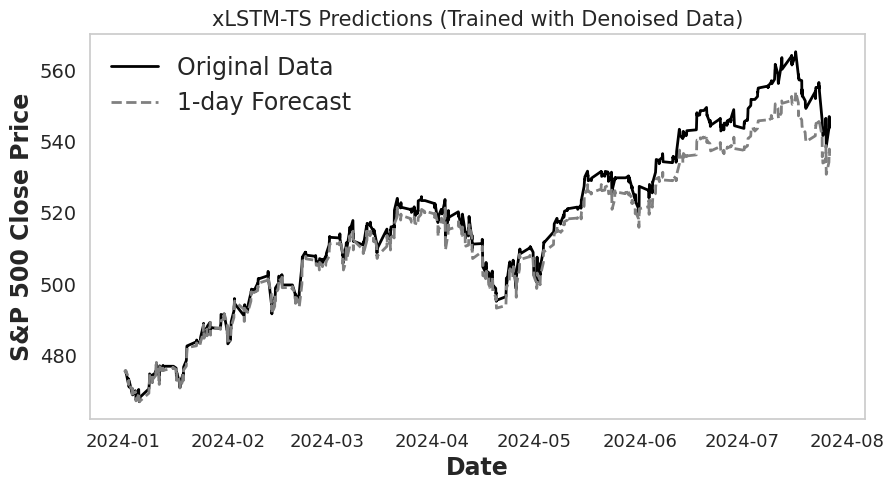

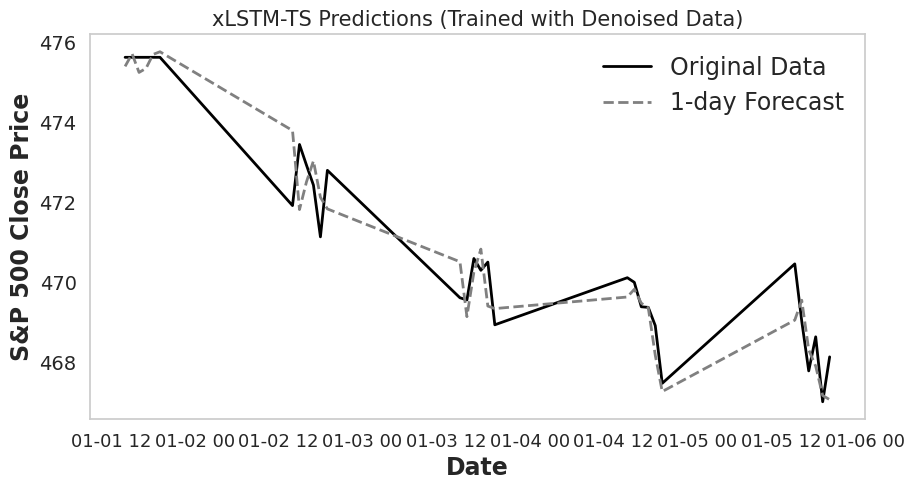

xLSTM-TS (Denoised) | Train Accuracy: 65.87%
xLSTM-TS (Denoised) | Validation Accuracy: 64.18%
xLSTM-TS (Denoised) | Test Accuracy: 66.07%
xLSTM-TS (Denoised) | Recall: 69.63%
xLSTM-TS (Denoised) | Precision (Rise): 66.05%
xLSTM-TS (Denoised) | Precision (Fall): 66.10%
xLSTM-TS (Denoised) | F1 Score: 67.79%


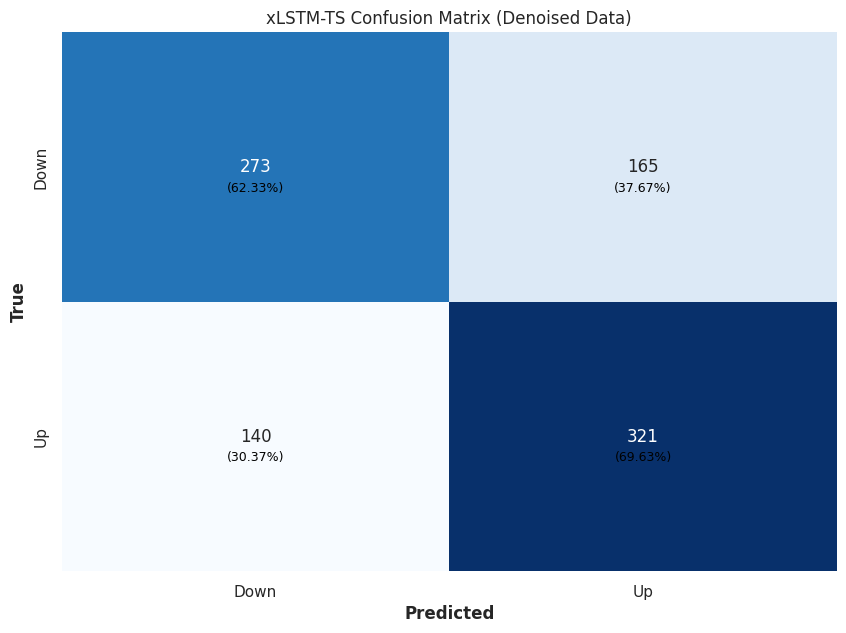

In [54]:
results_denoised_df, metrics_denoised = run_xlstm_ts(train_X_denoised, train_y_denoised, val_X_denoised, val_y_denoised, test_X_denoised, test_y, scaler_denoised, stock, 'Denoised', test_dates, train_y, val_y, test_y)

In [55]:
metrics_accumulator_denoised[model_name] = metrics_denoised

## Results

In [56]:
from ml.results.results import *

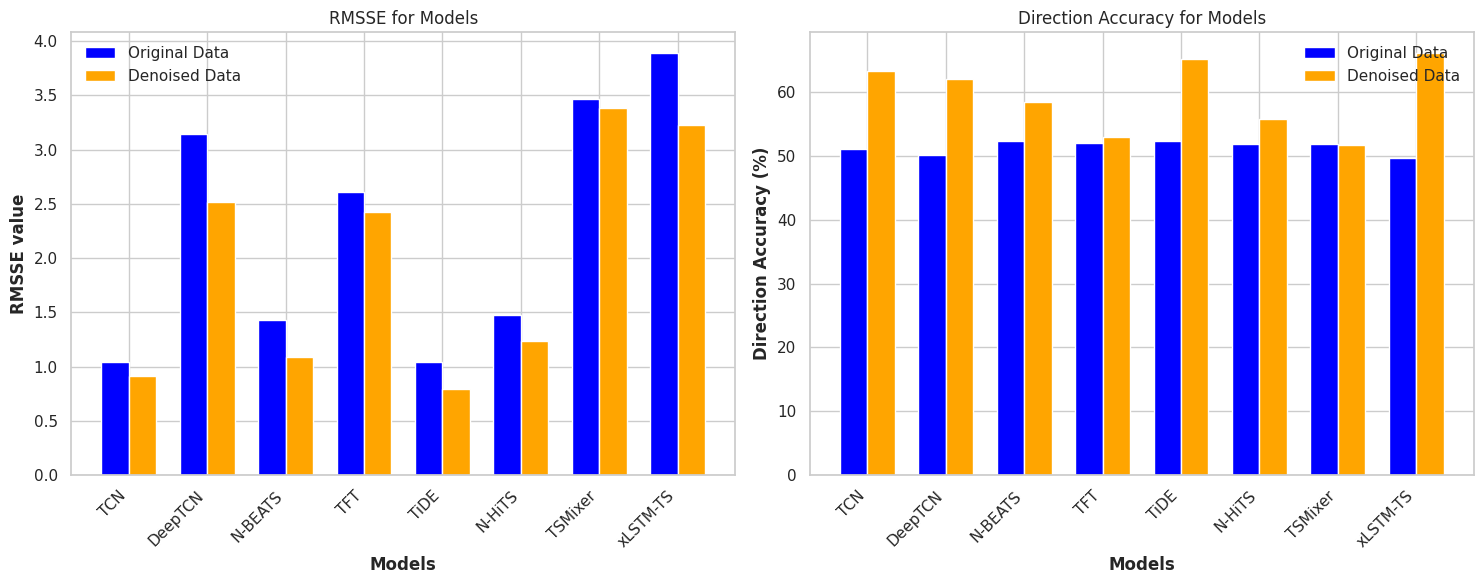

In [57]:
final_results = display_metrics(metrics_accumulator, metrics_accumulator_denoised)

In [58]:
original_data = show_results(final_results, 'Original')
denoised_data = show_results(final_results, 'Denoised')

In [59]:
original_data

MAE    MSE  RMSE  RMSSE   MAPE  MASE    R2 Test Accuracy  Recall  \
TCN       1.05   2.39  1.55   1.04  0.20%  1.11  0.99        51.06%  55.61%   
DeepTCN   3.01  21.78  4.67   3.14  0.56%  3.17  0.95        50.19%  54.88%   
N-BEATS   1.53   4.48  2.12   1.43  0.29%  1.61  0.99        52.32%  54.39%   
TFT       2.65  15.01  3.87   2.61  0.51%  2.79  0.96        52.07%  52.93%   
TiDE      1.06   2.41  1.55   1.05  0.20%  1.11  0.99        52.32%  55.12%   
N-HiTS    1.61   4.79  2.19   1.47  0.31%  1.70  0.99        51.81%  53.17%   
TSMixer   3.79  26.55  5.15   3.47  0.73%  3.99  0.93        51.94%  51.71%   
xLSTM-TS  4.84  31.84  5.64   3.89  0.92%  5.17  0.94        49.61%  53.36%   

         Precision (Rise) Precision (Fall) F1 Score Validation Accuracy  \
TCN                52.17%           49.72%   53.84%              49.19%   
DeepTCN            51.37%           48.75%   53.07%              46.24%   
N-BEATS            53.48%           51.05%   53.93%              51.69%   
TFT                53.32%           50.77%   53.12%              50.52%   
TiDE               53.43%           51.06%   54.26%              48.90%   
N-HiTS             53.04%           50.52%   53.11%              51.10%   
TSMixer            53.27%           50.62%   52.48%              52.58%   
xLSTM-TS           50.83%           48.19%   52.06%              46.73%   

         Train Accuracy  
TCN              50.55%  
DeepTCN          50.23%  
N-BEATS          52.45%  
TFT              50.77%  
TiDE             55.71%  
N-HiTS           51.03%  
TSMixer          50.25%  
xLSTM-TS         50.82%

In [60]:
denoised_data

MAE    MSE  RMSE  RMSSE   MAPE  MASE    R2 Test Accuracy  Recall  \
TCN       0.94   1.84  1.36   0.91  0.18%  0.99  1.00        63.33%  66.59%   
DeepTCN   2.52  14.00  3.74   2.52  0.47%  2.65  0.97        62.08%  67.07%   
N-BEATS   1.18   2.60  1.61   1.09  0.23%  1.24  0.99        58.45%  62.20%   
TFT       2.42  12.97  3.60   2.42  0.46%  2.55  0.97        52.94%  54.39%   
TiDE      0.83   1.40  1.18   0.80  0.16%  0.87  1.00        65.21%  69.27%   
N-HiTS    1.38   3.36  1.83   1.23  0.26%  1.45  0.99        55.82%  58.54%   
TSMixer   3.68  25.26  5.03   3.38  0.71%  3.88  0.94        51.69%  51.71%   
xLSTM-TS  3.59  22.01  4.69   3.23  0.67%  3.83  0.96        66.07%  69.63%   

         Precision (Rise) Precision (Fall) F1 Score Validation Accuracy  \
TCN                63.64%           62.97%   65.08%              61.27%   
DeepTCN            62.08%           62.08%   64.48%              62.15%   
N-BEATS            59.03%           57.77%   60.57%              58.17%   
TFT                54.13%           51.68%   54.26%              51.40%   
TiDE               65.14%           65.29%   67.14%              63.77%   
N-HiTS             56.74%           54.79%   57.62%              55.82%   
TSMixer            53.00%           50.38%   52.35%              51.84%   
xLSTM-TS           66.05%           66.10%   67.79%              64.18%   

         Train Accuracy  
TCN              64.80%  
DeepTCN          65.15%  
N-BEATS          60.67%  
TFT              53.17%  
TiDE             66.91%  
N-HiTS           57.17%  
TSMixer          50.66%  
xLSTM-TS         65.87%

## Export

Only for denoised values.

In [61]:
results_df.head(10)

Date       Close  Predicted Value  True Label  \
0 2024-01-01 14:00:00  475.359985       474.517365           0   
1 2024-01-01 15:00:00  475.359985       474.487518           0   
2 2024-01-01 16:00:00  475.359985       474.436249           0   
3 2024-01-01 17:00:00  475.359985       474.390411           0   
4 2024-01-01 18:00:00  475.359985       474.520386           0   
5 2024-01-01 19:00:00  475.359985       474.425903           0   
6 2024-01-02 14:00:00  471.660004       474.473938           1   
7 2024-01-02 15:00:00  473.184998       471.009399           0   
8 2024-01-02 16:00:00  472.669983       472.294281           0   
9 2024-01-02 17:00:00  472.170013       471.803925           0   

   Predicted Label  
0                0  
1                0  
2                0  
3                1  
4                0  
5                1  
6                0  
7                1  
8                0  
9                0

In [63]:
results_denoised_df.head(10)

Date       Close  Predicted Value  True Label  \
0 2024-01-01 14:00:00  475.617218       475.390686           0   
1 2024-01-01 15:00:00  475.617218       475.706024           0   
2 2024-01-01 16:00:00  475.617218       475.239685           0   
3 2024-01-01 17:00:00  475.617218       475.341766           0   
4 2024-01-01 18:00:00  475.617218       475.688538           0   
5 2024-01-01 19:00:00  475.617218       475.756104           0   
6 2024-01-02 14:00:00  471.914459       473.788788           1   
7 2024-01-02 15:00:00  473.440582       471.814789           0   
8 2024-01-02 16:00:00  472.925232       472.506073           0   
9 2024-01-02 17:00:00  472.424835       473.029877           0   

   Predicted Label  
0                1  
1                0  
2                1  
3                1  
4                1  
5                0  
6                0  
7                1  
8                1  
9                0

In [ ]:
# -- Save predictions as CSV --

%cd ..

save_results(results_df, results_denoised_df, 'hourly_sp500')

# -- Save the xLSTM-TS model --

# Rename the file
!mv xlstm-ts/best_model.pth xlstm_model_hourly_sp500.pth

# Download if necessary